In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import statistics as sc
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import  LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from prophet import Prophet
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Data Visualisation

In [2]:
calendar_data = pd.read_csv('calendar.csv')
calendar_data.columns[calendar_data.isnull().any()]

Index(['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2'], dtype='object')

In [3]:
calendar_data['date']

0       2011-01-29
1       2011-01-30
2       2011-01-31
3       2011-02-01
4       2011-02-02
           ...    
1964    2016-06-15
1965    2016-06-16
1966    2016-06-17
1967    2016-06-18
1968    2016-06-19
Name: date, Length: 1969, dtype: object

In [4]:
calendar_data.duplicated().sum()

0

In [5]:
calendar_data['year'] = calendar_data['wm_yr_wk'].apply(lambda x : int('20'+str(x)[1:3]))
calendar_data['week'] = calendar_data['wm_yr_wk'].apply(lambda x : int(str(x)[3:]))

In [6]:
calendar_data

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0,1
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0,1
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0,1
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0,1
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,20
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,20
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,20
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,21


In [7]:
event_data = pd.read_csv('events.csv')
event_data

,Unnamed: 0,date,event_name_1,event_type_1
0,0,2015-04-05,Easter,Cultural
1,1,2015-04-11,Pesach End,Religious
2,2,2015-04-12,OrthodoxEaster,Religious
3,3,2015-05-05,Cinco De Mayo,Cultural
4,4,2015-05-10,Mother's day,Cultural
5,5,2015-05-25,MemorialDay,National
6,6,2015-06-04,NBAFinalsStart,Sporting
7,7,2015-06-16,NBAFinalsEnd,Sporting
8,8,2015-06-18,Ramadan starts,Religious
9,9,2015-06-21,Father's day,Cultural


In [8]:
event_data_2015 = pd.read_csv('events_2015.csv')
event_data_2015

,Unnamed: 0,date,event_name_1,event_type_1,current_sales,max_sales,mean_sales,factor
0,1527,2015-04-05,Easter,Cultural,11.20,17.92,7.36,2.434783
1,1533,2015-04-11,Pesach End,Religious,8.96,47.04,12.80,3.675000
2,1534,2015-04-12,OrthodoxEaster,Religious,4.48,47.04,11.84,3.972973
3,1557,2015-05-05,Cinco De Mayo,Cultural,4.48,20.16,8.64,2.333333
4,1562,2015-05-10,Mother's day,Cultural,4.48,15.68,10.24,1.531250
5,1577,2015-05-25,MemorialDay,National,20.16,20.16,10.24,1.968750
6,1587,2015-06-04,NBAFinalsStart,Sporting,4.48,17.92,8.96,2.000000
7,1599,2015-06-16,NBAFinalsEnd,Sporting,2.24,31.36,13.12,2.390244
8,1601,2015-06-18,Ramadan starts,Religious,4.48,20.16,9.92,2.032258
9,1604,2015-06-21,Father's day,Cultural,17.92,20.16,10.24,1.968750


In [9]:
merged_data = pd.merge(calendar_data,event_data,on="date")
merged_data.shape

(20, 18)

In [10]:
sales_data = pd.read_csv('Total_sales.csv')
sales_data

,Unnamed: 0,FOODS_1_001_CA_1_validation,FOODS_1_001_CA_2_validation,FOODS_1_001_CA_3_validation,FOODS_1_001_CA_4_validation,FOODS_1_001_TX_1_validation,FOODS_1_001_TX_2_validation,FOODS_1_001_TX_3_validation,FOODS_1_001_WI_1_validation,FOODS_1_001_WI_2_validation,...,HOUSEHOLD_2_516_CA_2_validation,HOUSEHOLD_2_516_CA_3_validation,HOUSEHOLD_2_516_CA_4_validation,HOUSEHOLD_2_516_TX_1_validation,HOUSEHOLD_2_516_TX_2_validation,HOUSEHOLD_2_516_TX_3_validation,HOUSEHOLD_2_516_WI_1_validation,HOUSEHOLD_2_516_WI_2_validation,HOUSEHOLD_2_516_WI_3_validation,date
0,0,6.00,4.00,2.00,0.00,0.0,0.00,NaN,0.00,NaN,...,NaN,0.00,NaN,NaN,0.00,11.88,0.00,NaN,NaN,2011-01-29
1,1,0.00,0.00,4.00,2.00,2.0,0.00,NaN,4.00,NaN,...,NaN,5.94,NaN,NaN,5.94,0.00,0.00,NaN,NaN,2011-01-30
2,2,0.00,0.00,2.00,2.00,2.0,2.00,NaN,0.00,NaN,...,NaN,0.00,NaN,NaN,0.00,0.00,0.00,NaN,NaN,2011-01-31
3,3,2.00,0.00,2.00,2.00,0.0,4.00,NaN,2.00,NaN,...,NaN,5.94,NaN,NaN,0.00,0.00,5.94,NaN,NaN,2011-02-01
4,4,8.00,2.00,2.00,2.00,0.0,0.00,NaN,0.00,NaN,...,NaN,0.00,NaN,NaN,0.00,0.00,0.00,NaN,NaN,2011-02-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,1908,2.24,2.24,0.00,0.00,0.0,0.00,0.00,0.00,NaN,...,0.0,0.00,0.00,0.0,5.94,0.00,0.00,NaN,NaN,2016-04-20
1909,1909,0.00,8.96,0.00,0.00,0.0,0.00,4.48,0.00,NaN,...,0.0,0.00,0.00,0.0,0.00,0.00,0.00,NaN,NaN,2016-04-21
1910,1910,2.24,0.00,0.00,2.24,0.0,0.00,0.00,0.00,NaN,...,0.0,0.00,0.00,0.0,0.00,0.00,0.00,NaN,NaN,2016-04-22
1911,1911,2.24,0.00,2.24,2.24,0.0,2.24,0.00,17.92,NaN,...,0.0,0.00,0.00,0.0,0.00,0.00,0.00,NaN,NaN,2016-04-23


In [11]:
sales_data.head()
sales_and_dates = pd.merge(calendar_data,sales_data,on='date')

In [12]:
sales_validation = pd.read_csv('sales_train_validation.csv')
sales_validation[sales_validation['cat_id']=='FOODS']
stores = sales_validation['store_id'].unique()
states = sales_validation['state_id'].unique()
stores

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [13]:
master_data = pd.read_csv('Master.csv')
master_data.isnull().sum()

Unnamed: 0                        0
FOODS_1_001_CA_1_validation       0
FOODS_1_001_CA_2_validation       0
FOODS_1_001_CA_3_validation       0
FOODS_1_001_CA_4_validation       0
                               ... 
WI_1                           1841
WI_2                           1913
WI_3                           1913
date                              0
sum                               0
Length: 30509, dtype: int64

In [14]:
kaggle_data = pd.read_csv('kaggle_subset.csv')

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\2793981484.py:1: DtypeWarning: Columns (30542,30543,30621,30622) have mixed types. Specify dtype option on import or set low_memory=False.
  kaggle_data = pd.read_csv('kaggle_subset.csv')


In [15]:
columns_to_drop = [column for column in kaggle_data.columns if 'validation' in column.split("_") or str(column)=='Unnamed']
# columns_to_drop.append('Unnamed')
trim_data = kaggle_data.iloc[:,1:].drop(columns=columns_to_drop)
trim_data.head()

,Total,CA,TX,WI,date,FOODS,HOBBIES,HOUSEHOLD,CA_1,CA_2,...,HOUSEHOLD2CA3,HOUSEHOLD2CA4,HOUSEHOLD2TX1,HOUSEHOLD2TX2,HOUSEHOLD2TX3,HOUSEHOLD2WI1,HOUSEHOLD2WI2,HOUSEHOLD2WI3,event_name_2,event_type_2
0,67896.68,36276.10,24100.45,7520.13,2011-01-29,39483.58,8965.79,19447.31,10933.16,9101.52,...,1482.98,326.03,569.91,1006.67,616.73,776.95,0.0,0.0,NaN,NaN
1,65396.94,35047.46,23771.68,6577.80,2011-01-30,37978.16,7740.22,19678.56,9787.06,8417.53,...,1761.41,460.73,749.14,869.76,682.58,780.70,0.0,0.0,NaN,NaN
2,46430.26,25283.73,16609.83,4536.70,2011-01-31,27147.85,6109.06,13173.35,7201.38,5320.51,...,1200.57,362.80,351.49,597.81,444.37,356.77,0.0,0.0,NaN,NaN
3,48781.39,26917.00,17957.96,3906.43,2011-02-01,29745.69,6069.94,12965.76,7407.74,5550.56,...,1277.44,365.75,407.28,498.49,381.69,235.29,0.0,0.0,NaN,NaN
4,39955.72,25175.63,14455.86,324.23,2011-02-02,25090.32,4923.09,9942.31,6566.12,5229.72,...,1357.44,350.51,294.77,459.66,179.80,0.00,0.0,0.0,NaN,NaN


In [16]:
year = []
for date in calendar_data['date']:
    num = str(date).split('-')
    year.append(int(num[0]))
calendar_data['year'] = year
calendar_data[calendar_data['year']==2016]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,week
1798,2016-01-01,11548,Friday,7,1,2016,d_1799,NewYear,National,NaN,NaN,1,1,0,48
1799,2016-01-02,11549,Saturday,1,1,2016,d_1800,NaN,NaN,NaN,NaN,1,0,1,49
1800,2016-01-03,11549,Sunday,2,1,2016,d_1801,NaN,NaN,NaN,NaN,1,1,1,49
1801,2016-01-04,11549,Monday,3,1,2016,d_1802,NaN,NaN,NaN,NaN,1,0,0,49
1802,2016-01-05,11549,Tuesday,4,1,2016,d_1803,NaN,NaN,NaN,NaN,1,1,1,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1,20
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0,20
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0,20
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0,21


In [17]:
date_trim_data = pd.merge(trim_data,calendar_data,on='date')
date_trim_data[date_trim_data['event_name_1_y'].notnull()]
years = date_trim_data.pop('year')
weeks = date_trim_data.pop('week')
months = date_trim_data.pop('month')
date_trim_data.insert(5,'year',years)
date_trim_data.insert(6,'month',months)
date_trim_data.insert(7,'week',weeks)
date_trim_data

,Total,CA,TX,WI,date,year,month,week,FOODS,HOBBIES,...,weekday,wday,d,event_name_1_y,event_type_1_y,event_name_2_y,event_type_2_y,snap_CA_y,snap_TX_y,snap_WI_y
0,67896.68,36276.10,24100.45,7520.13,2011-01-29,2011,1,1,39483.58,8965.79,...,Saturday,1,d_1,NaN,NaN,NaN,NaN,0,0,0
1,65396.94,35047.46,23771.68,6577.80,2011-01-30,2011,1,1,37978.16,7740.22,...,Sunday,2,d_2,NaN,NaN,NaN,NaN,0,0,0
2,46430.26,25283.73,16609.83,4536.70,2011-01-31,2011,1,1,27147.85,6109.06,...,Monday,3,d_3,NaN,NaN,NaN,NaN,0,0,0
3,48781.39,26917.00,17957.96,3906.43,2011-02-01,2011,2,1,29745.69,6069.94,...,Tuesday,4,d_4,NaN,NaN,NaN,NaN,1,1,0
4,39955.72,25175.63,14455.86,324.23,2011-02-02,2011,2,1,25090.32,4923.09,...,Wednesday,5,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,93507.19,50003.75,31321.65,12181.79,2016-04-20,2016,4,12,50334.45,14360.80,...,Wednesday,5,d_1909,NaN,NaN,NaN,NaN,0,0,0
1909,90613.09,46834.62,31205.16,12573.31,2016-04-21,2016,4,12,49017.95,13395.77,...,Thursday,6,d_1910,NaN,NaN,NaN,NaN,0,0,0
1910,104324.80,55652.00,33884.35,14788.45,2016-04-22,2016,4,12,55480.95,15467.42,...,Friday,7,d_1911,NaN,NaN,NaN,NaN,0,0,0
1911,129296.53,72937.13,39042.59,17316.81,2016-04-23,2016,4,13,66564.98,19746.70,...,Saturday,1,d_1912,NaN,NaN,NaN,NaN,0,0,0


In [18]:
categories = np.array(['FOODS','HOBBIES','HOUSEHOLD'])
categories

array(['FOODS', 'HOBBIES', 'HOUSEHOLD'], dtype='<U9')

In [19]:
disaster_data = pd.read_csv('us_disaster_declarations.csv')
# disaster_data = disaster_data[disaster_data['fy_declared']>2010]
disaster_data = disaster_data[disaster_data['fy_declared'].isin(range(2011,2017))]
disaster_data = disaster_data[disaster_data['state'].isin(states)].drop(columns=['disaster_number','fema_declaration_string','place_code','declaration_request_number','hash','id'])
disaster_data = disaster_data.reset_index().iloc[:,1:]

In [20]:
total_sales = pd.read_csv("Total_sales.csv")
total_sales.columns



Index(['Unnamed: 0', 'FOODS_1_001_CA_1_validation',
       'FOODS_1_001_CA_2_validation', 'FOODS_1_001_CA_3_validation',
       'FOODS_1_001_CA_4_validation', 'FOODS_1_001_TX_1_validation',
       'FOODS_1_001_TX_2_validation', 'FOODS_1_001_TX_3_validation',
       'FOODS_1_001_WI_1_validation', 'FOODS_1_001_WI_2_validation',
       ...
       'HOUSEHOLD_2_516_CA_2_validation', 'HOUSEHOLD_2_516_CA_3_validation',
       'HOUSEHOLD_2_516_CA_4_validation', 'HOUSEHOLD_2_516_TX_1_validation',
       'HOUSEHOLD_2_516_TX_2_validation', 'HOUSEHOLD_2_516_TX_3_validation',
       'HOUSEHOLD_2_516_WI_1_validation', 'HOUSEHOLD_2_516_WI_2_validation',
       'HOUSEHOLD_2_516_WI_3_validation', 'date'],
      dtype='object', length=30492)

# Find total sales of all stores
# monthly sales 
# plot category vs state sales
# plot state's top store vs category sales
# plot month and year-wise sales 
# find statistical basis of temporal sales drop
# find future predictions of sales and find some marketing strategies
# state-wise sales (done)

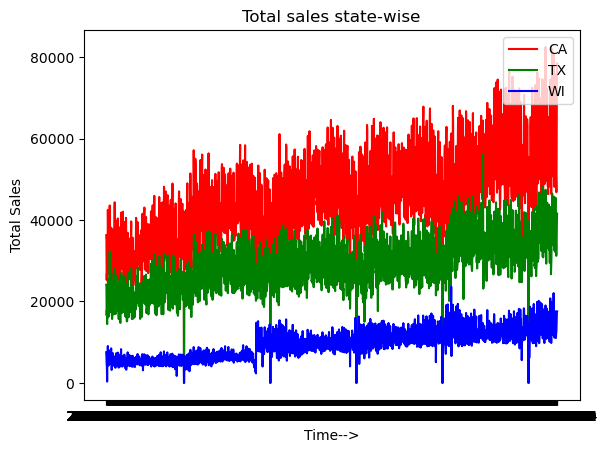

In [21]:
color = ['red','green','blue','yellow','violet','orange']
for i in range(len(states)):
    plt.plot(date_trim_data['date'],date_trim_data[states[i]],color=color[i])
labels = [(str(state)) for state,color in zip(states,color)]
plt.legend(labels,loc = 'upper right')
plt.title('Total sales state-wise')
plt.xlabel('Time-->')
plt.ylabel('Total Sales')
plt.show()

In [22]:
stores

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [23]:
state_monthly_sum = {}
for state in states:
    state_monthly_sum[state] = date_trim_data.groupby(['year'])[state].sum().reset_index()
state_monthly_sum['TX']

,year,TX
0,2011,7206181.77
1,2012,9656470.69
2,2013,10236247.15
3,2014,10594431.89
4,2015,12221559.77
5,2016,4129235.67


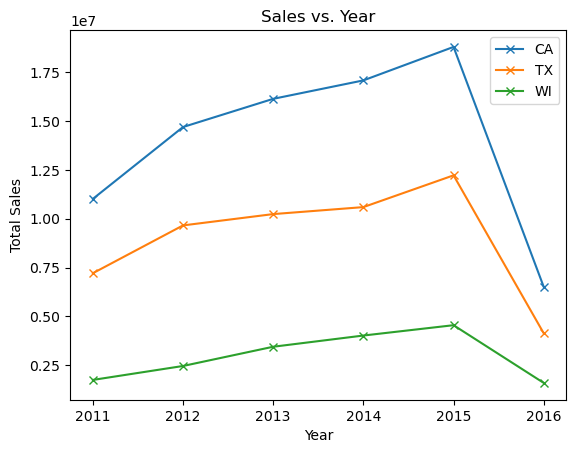

In [24]:
for state in states:
    plt.plot(state_monthly_sum[state]['year'].values,state_monthly_sum[state][state].values,marker='x',linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Sales vs. Year')
label = [(str(state)) for state,c in zip(states,color[:4])]
plt.legend(label,loc='upper right')
plt.xticks(state_monthly_sum[states[0]]['year'])
plt.show()

# Decrease in sales after 2015
### It could be due to shift to online purchases

In [25]:
category_monthly_sum = {}
for category in categories:
    category_monthly_sum[category] = date_trim_data.groupby(['year'])[category].sum().reset_index()
category_monthly_sum['HOBBIES']

,year,HOBBIES
0,2011,2397131.38
1,2012,3129681.58
2,2013,4076353.84
3,2014,4181336.97
4,2015,5564899.26
5,2016,1843530.38


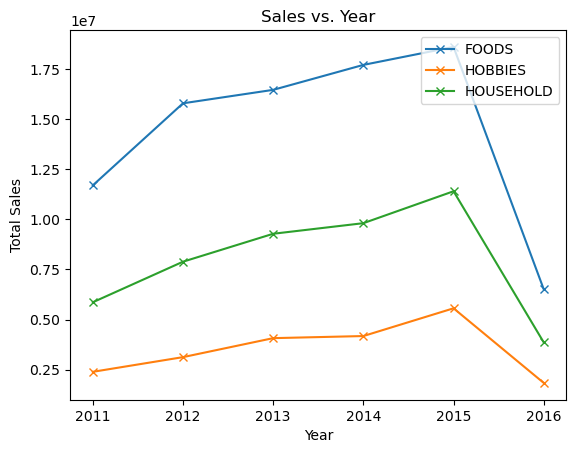

In [26]:
for category in categories:
    plt.plot(category_monthly_sum[category]['year'].values,category_monthly_sum[category][category].values,marker='x',linestyle='-')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Sales vs. Year')
label = [(str(category)) for category,c in zip(categories,color[:4])]
plt.legend(label,loc='upper right')
plt.xticks(category_monthly_sum[categories[0]]['year'])
plt.show()

In [27]:
CA_stores = [store for store in stores if store.split('_')[0]=='CA']
WI_stores = [store for store in stores if store.split('_')[0]=='WI']
TX_stores = [store for store in stores if store.split('_')[0]=='TX']

stores = [CA_stores,WI_stores,TX_stores]

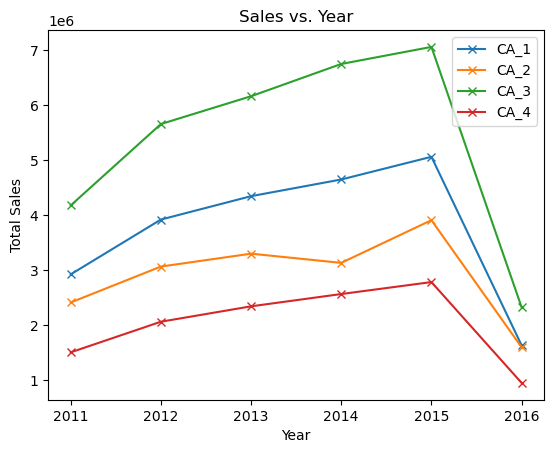

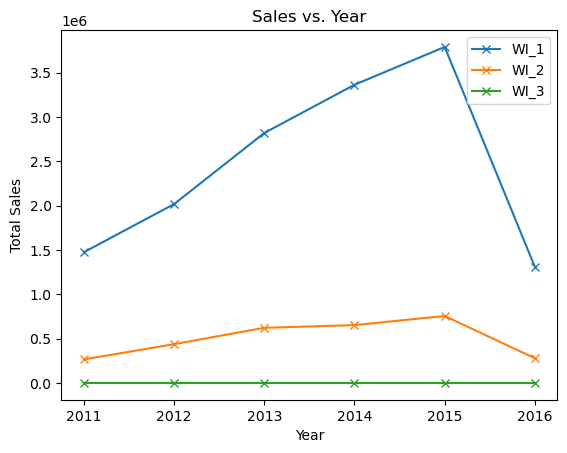

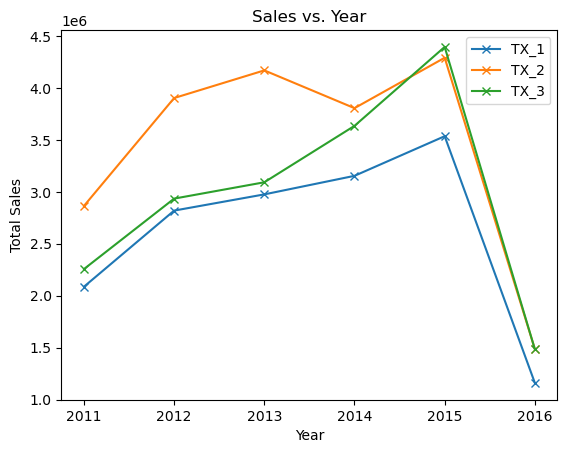

In [28]:
for store in stores:
    storewise_monthly_sum = {}
    for s in store:
        storewise_monthly_sum[s] = date_trim_data.groupby(['year'])[s].sum().reset_index()
    for s in store:
        plt.plot(storewise_monthly_sum[s]['year'].values,storewise_monthly_sum[s][s].values,marker='x',linestyle='-')
    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title('Sales vs. Year')
    label = [(str(s)) for s,c in zip(store,color[:len(store)])]
    plt.legend(label,loc='upper right')
    plt.xticks(storewise_monthly_sum[store[0]]['year'])
    plt.show()

# TX seems to be the state which saw the biggest relative decline in all stores

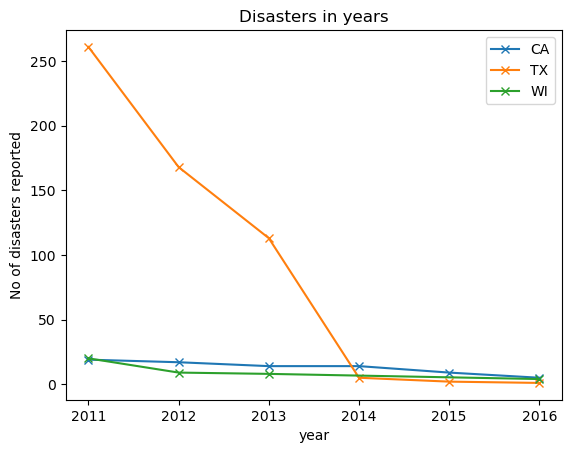

In [29]:
for state in states:
    year_counts = disaster_data[disaster_data['state']==state]['fy_declared'].value_counts()
    plt.plot(disaster_data[disaster_data['state']==state]['fy_declared'].unique(),year_counts,marker='x',linestyle='-')
plt.title('Disasters in years')
label = [(str(d)) for d,c in zip(states,color[:len(states)])]
plt.legend(label,loc='upper right')
plt.xlabel('year')
plt.ylabel('No of disasters reported')
plt.show()

### Analysis of 2015 sales and events

In [30]:
date_trim_data

,Total,CA,TX,WI,date,year,month,week,FOODS,HOBBIES,...,weekday,wday,d,event_name_1_y,event_type_1_y,event_name_2_y,event_type_2_y,snap_CA_y,snap_TX_y,snap_WI_y
0,67896.68,36276.10,24100.45,7520.13,2011-01-29,2011,1,1,39483.58,8965.79,...,Saturday,1,d_1,NaN,NaN,NaN,NaN,0,0,0
1,65396.94,35047.46,23771.68,6577.80,2011-01-30,2011,1,1,37978.16,7740.22,...,Sunday,2,d_2,NaN,NaN,NaN,NaN,0,0,0
2,46430.26,25283.73,16609.83,4536.70,2011-01-31,2011,1,1,27147.85,6109.06,...,Monday,3,d_3,NaN,NaN,NaN,NaN,0,0,0
3,48781.39,26917.00,17957.96,3906.43,2011-02-01,2011,2,1,29745.69,6069.94,...,Tuesday,4,d_4,NaN,NaN,NaN,NaN,1,1,0
4,39955.72,25175.63,14455.86,324.23,2011-02-02,2011,2,1,25090.32,4923.09,...,Wednesday,5,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,93507.19,50003.75,31321.65,12181.79,2016-04-20,2016,4,12,50334.45,14360.80,...,Wednesday,5,d_1909,NaN,NaN,NaN,NaN,0,0,0
1909,90613.09,46834.62,31205.16,12573.31,2016-04-21,2016,4,12,49017.95,13395.77,...,Thursday,6,d_1910,NaN,NaN,NaN,NaN,0,0,0
1910,104324.80,55652.00,33884.35,14788.45,2016-04-22,2016,4,12,55480.95,15467.42,...,Friday,7,d_1911,NaN,NaN,NaN,NaN,0,0,0
1911,129296.53,72937.13,39042.59,17316.81,2016-04-23,2016,4,13,66564.98,19746.70,...,Saturday,1,d_1912,NaN,NaN,NaN,NaN,0,0,0


In [31]:
sales_2015 = date_trim_data[date_trim_data['year']==2015]
months_dup = sales_2015['month'].values
months_dup = [float(m) for m in months_dup]
sales_2015['month'] = months_dup

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\235011629.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_2015['month'] = months_dup


In [32]:
event_types = event_data_2015['event_type_1'].unique()
event_types

array(['Cultural', 'Religious', 'National', 'Sporting'], dtype=object)

In [33]:
float_columns = sales_2015.select_dtypes(include=['float64','float32'])
monthly_sales_2015 = float_columns.groupby('month').sum()
monthly_sales_2015 = monthly_sales_2015.reset_index()
monthly_sales_2015

,month,Total,CA,TX,WI,FOODS,HOBBIES,HOUSEHOLD,CA_1,CA_2,...,HOUSEHOLD2CA1,HOUSEHOLD2CA2,HOUSEHOLD2CA3,HOUSEHOLD2CA4,HOUSEHOLD2TX1,HOUSEHOLD2TX2,HOUSEHOLD2TX3,HOUSEHOLD2WI1,HOUSEHOLD2WI2,HOUSEHOLD2WI3
0,1.0,2729981.86,1428173.11,923879.83,377928.92,1506833.47,407805.85,815342.54,401896.85,249262.38,...,25801.30,34257.34,41429.77,15966.67,20490.59,19558.19,18277.20,21524.11,0.0,0.0
1,2.0,2619667.52,1325499.34,931852.70,362315.48,1385475.31,412170.24,822021.97,372124.43,213945.75,...,26561.92,33534.87,41401.40,14739.22,18981.09,24168.32,20797.83,21322.38,0.0,0.0
2,3.0,2955307.77,1510218.03,1067839.42,377250.32,1525150.91,477713.42,952443.44,419717.12,249461.77,...,32762.49,42426.40,49850.88,18443.84,22759.53,29387.56,23541.37,24560.10,0.0,0.0
3,4.0,2867636.64,1473305.23,1034074.48,360256.93,1491621.75,460011.28,916003.61,421798.93,241357.14,...,33176.21,42115.22,50123.48,18710.03,20965.39,26589.00,21464.04,21881.34,0.0,0.0
4,5.0,3035375.17,1563556.65,1086840.90,384977.62,1560042.86,489461.17,985871.14,446621.71,265997.45,...,35640.93,44874.97,51953.62,19829.31,23869.02,28147.92,23747.81,22485.61,0.0,0.0
5,6.0,2919193.72,1554915.26,999972.54,364305.92,1523890.26,453407.85,941895.61,415932.34,321285.35,...,33765.72,42208.77,50625.71,18911.24,23666.01,25436.74,21057.81,21844.51,0.0,0.0
6,7.0,3105456.48,1659815.44,1058435.43,387205.61,1619251.91,472761.67,1013442.90,437933.35,365368.68,...,35820.76,46855.47,54607.82,19095.65,25218.61,29016.89,23481.27,23381.00,0.0,0.0
7,8.0,3204908.84,1755863.26,1064166.58,384879.00,1643685.53,482181.58,1079041.73,455646.57,402649.89,...,36077.47,49287.58,57702.24,19021.56,25309.31,29285.34,23185.55,22749.46,0.0,0.0
8,9.0,2994907.84,1639157.87,988880.02,366869.95,1570335.31,449277.68,975294.85,423416.85,384822.21,...,30555.02,43613.51,47050.46,15657.63,20707.90,23516.15,20535.34,19279.24,0.0,0.0
9,10.0,3194045.91,1729761.18,1061956.71,402328.02,1702068.82,489379.04,1002598.05,442839.59,420502.78,...,32768.87,46945.85,47173.31,16536.60,21245.09,24613.83,22801.05,20045.14,0.0,0.0


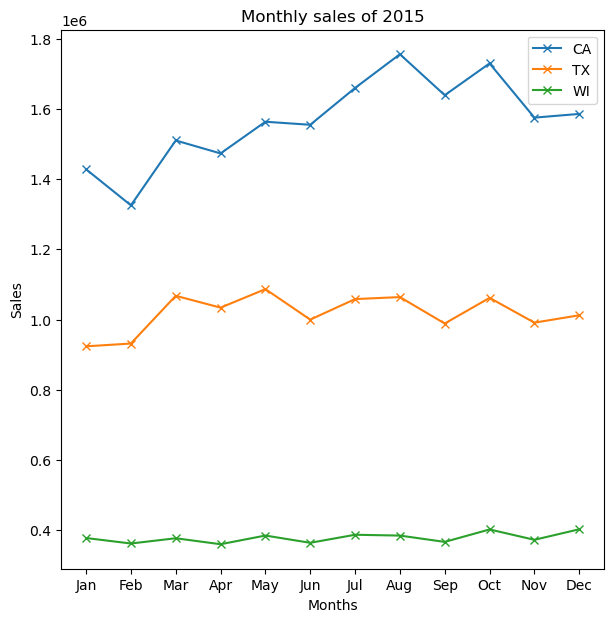

In [34]:
plt.figure(figsize=(7,7))
for state in states:
    plt.plot(monthly_sales_2015['month'],monthly_sales_2015[state],marker='x',linestyle='-')
plt.title('Monthly sales of 2015')
label = [(str(state)) for state,c in zip(states,color[:len(states)])]
plt.legend(label,loc='upper right')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.xticks(range(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

In [35]:
sales_2015

,Total,CA,TX,WI,date,year,month,week,FOODS,HOBBIES,...,weekday,wday,d,event_name_1_y,event_type_1_y,event_name_2_y,event_type_2_y,snap_CA_y,snap_TX_y,snap_WI_y
1433,70219.41,36033.10,24597.75,9588.56,2015-01-01,2015,1.0,48,37349.18,10804.20,...,Thursday,6,d_1434,NewYear,National,NaN,NaN,1,1,0
1434,98346.96,50740.11,31793.04,15813.81,2015-01-02,2015,1.0,48,50488.49,16832.06,...,Friday,7,d_1435,NaN,NaN,NaN,NaN,1,0,1
1435,103940.57,56010.92,33738.11,14191.54,2015-01-03,2015,1.0,49,55986.57,14937.61,...,Saturday,1,d_1436,NaN,NaN,NaN,NaN,1,1,1
1436,104183.98,58332.48,33264.70,12586.80,2015-01-04,2015,1.0,49,60807.60,13580.04,...,Sunday,2,d_1437,NaN,NaN,NaN,NaN,1,0,0
1437,88126.38,48192.93,30481.08,9452.37,2015-01-05,2015,1.0,49,51609.10,12283.06,...,Monday,3,d_1438,NaN,NaN,NaN,NaN,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,100319.80,54653.13,32201.97,13464.70,2015-12-27,2015,12.0,48,48237.36,17172.54,...,Sunday,2,d_1794,NaN,NaN,NaN,NaN,0,0,0
1794,86694.25,49734.73,30778.48,6181.04,2015-12-28,2015,12.0,48,42977.51,13727.94,...,Monday,3,d_1795,NaN,NaN,NaN,NaN,0,0,0
1795,87578.19,48709.35,29091.51,9777.33,2015-12-29,2015,12.0,48,43003.98,14466.18,...,Tuesday,4,d_1796,NaN,NaN,NaN,NaN,0,0,0
1796,91287.58,49106.62,28907.80,13273.16,2015-12-30,2015,12.0,48,46236.14,15239.19,...,Wednesday,5,d_1797,NaN,NaN,NaN,NaN,0,0,0


In [36]:
august_weekdays = sales_2015[(sales_2015['month'] == 8.0)]

august_weekdays

,Total,CA,TX,WI,date,year,month,week,FOODS,HOBBIES,...,weekday,wday,d,event_name_1_y,event_type_1_y,event_name_2_y,event_type_2_y,snap_CA_y,snap_TX_y,snap_WI_y
1645,127839.65,69022.88,41920.99,16895.78,2015-08-01,2015,8.0,27,62972.00,19804.86,...,Saturday,1,d_1646,NaN,NaN,NaN,NaN,1,1,0
1646,130123.83,72407.81,42090.45,15625.57,2015-08-02,2015,8.0,27,66882.94,18681.29,...,Sunday,2,d_1647,NaN,NaN,NaN,NaN,1,0,1
1647,111392.90,57912.27,39686.51,13794.12,2015-08-03,2015,8.0,27,57747.10,16485.72,...,Monday,3,d_1648,NaN,NaN,NaN,NaN,1,1,1
1648,95693.37,52683.72,31923.49,11086.16,2015-08-04,2015,8.0,27,49256.53,15373.01,...,Tuesday,4,d_1649,NaN,NaN,NaN,NaN,1,0,0
1649,94251.79,50341.30,32159.31,11751.18,2015-08-05,2015,8.0,27,51757.46,14040.44,...,Wednesday,5,d_1650,NaN,NaN,NaN,NaN,1,1,1
1650,94111.29,50150.12,33832.94,10128.23,2015-08-06,2015,8.0,27,51262.71,13998.22,...,Thursday,6,d_1651,NaN,NaN,NaN,NaN,1,1,1
1651,103947.39,55299.04,36061.81,12586.54,2015-08-07,2015,8.0,27,55680.57,15214.27,...,Friday,7,d_1652,NaN,NaN,NaN,NaN,1,1,0
1652,122426.17,68581.88,40452.76,13391.53,2015-08-08,2015,8.0,28,63925.71,17881.33,...,Saturday,1,d_1653,NaN,NaN,NaN,NaN,1,0,1
1653,132401.93,73777.03,44348.70,14276.20,2015-08-09,2015,8.0,28,70203.96,18398.43,...,Sunday,2,d_1654,NaN,NaN,NaN,NaN,1,1,1
1654,99093.70,56181.08,32848.41,10064.21,2015-08-10,2015,8.0,28,52950.75,13649.11,...,Monday,3,d_1655,NaN,NaN,NaN,NaN,1,0,0


In [37]:
august_weekend_days = august_weekdays[(august_weekdays['wday']<=2)]

august_weekend_days = august_weekend_days.groupby('week').sum().reset_index()
weeks = august_weekend_days['week']
weeks = [float(m) for m in weeks]
august_weekend_days['week']  = weeks
august_weekend_days = august_weekend_days.select_dtypes(include=['float64','float32'])
august_weekend_days

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\932970380.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  august_weekend_days = august_weekend_days.groupby('week').sum().reset_index()


,week,Total,CA,TX,WI,month,FOODS,HOBBIES,HOUSEHOLD,CA_1,...,HOUSEHOLD2CA1,HOUSEHOLD2CA2,HOUSEHOLD2CA3,HOUSEHOLD2CA4,HOUSEHOLD2TX1,HOUSEHOLD2TX2,HOUSEHOLD2TX3,HOUSEHOLD2WI1,HOUSEHOLD2WI2,HOUSEHOLD2WI3
0,27.0,257963.48,141430.69,84011.44,32521.35,16.0,129854.94,38486.15,89622.39,39054.02,...,2685.73,4292.78,4296.56,1352.15,1968.34,2303.11,1688.07,2037.47,0.0,0.0
1,28.0,254828.10,142358.91,84801.46,27667.73,16.0,134129.67,36279.76,84418.67,38893.72,...,3032.42,3990.92,4420.58,1251.19,1920.91,2132.35,1839.37,1371.31,0.0,0.0
2,29.0,254617.49,142002.82,83965.72,28648.95,16.0,130694.44,36278.34,87644.71,36623.88,...,2861.03,4248.31,4803.79,1384.16,2274.88,2465.08,1800.95,1686.75,0.0,0.0
3,30.0,247708.44,136891.93,82285.09,28531.42,16.0,121130.77,37157.65,89420.02,35872.34,...,2833.81,4292.74,4596.57,1205.13,1928.63,2559.07,2260.71,1848.37,0.0,0.0
4,31.0,243913.19,136761.10,76230.13,30921.96,16.0,121270.10,36154.78,86488.31,35584.19,...,2986.58,4744.03,4109.70,1485.15,1735.15,2120.01,1732.93,1695.47,0.0,0.0


In [38]:
august_weekday_days = august_weekdays[(august_weekdays['wday']>2)]

august_weekday_days = august_weekday_days.groupby('week').sum().reset_index()
weeks = august_weekday_days['week']
weeks = [float(m) for m in weeks]
august_weekday_days['week']  = weeks
august_weekday_days = august_weekday_days.select_dtypes(include=['float64','float32'])
august_weekday_days


C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\1435733880.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  august_weekday_days = august_weekday_days.groupby('week').sum().reset_index()


,week,Total,CA,TX,WI,month,FOODS,HOBBIES,HOUSEHOLD,CA_1,...,HOUSEHOLD2CA1,HOUSEHOLD2CA2,HOUSEHOLD2CA3,HOUSEHOLD2CA4,HOUSEHOLD2TX1,HOUSEHOLD2TX2,HOUSEHOLD2TX3,HOUSEHOLD2WI1,HOUSEHOLD2WI2,HOUSEHOLD2WI3
0,27.0,499396.74,266386.45,173664.06,59346.23,40.0,265704.37,75111.66,158580.71,71259.23,...,5489.48,6599.21,8719.34,3125.36,3671.60,4552.73,3475.43,3486.82,0.0,0.0
1,28.0,470358.66,254237.88,161995.14,54125.64,40.0,248724.18,68321.09,153313.39,64538.42,...,5250.80,7032.60,9083.06,2905.07,3911.80,4418.04,3254.36,3218.21,0.0,0.0
2,29.0,457500.31,254646.06,147822.40,55031.85,40.0,231723.28,70088.58,155688.45,64768.14,...,5165.14,6730.42,8566.39,3038.74,4295.61,4247.29,3328.30,3176.37,0.0,0.0
3,30.0,427640.94,230447.03,140655.07,56538.84,40.0,214487.63,69399.85,143753.46,56106.02,...,4655.03,6121.35,7597.71,2577.99,2994.06,3734.48,3153.23,3557.12,0.0,0.0
4,31.0,90981.49,50700.39,28736.07,11545.03,8.0,45966.15,14903.72,30111.62,12946.61,...,1117.45,1235.22,1508.54,696.62,608.33,753.18,652.20,671.57,0.0,0.0


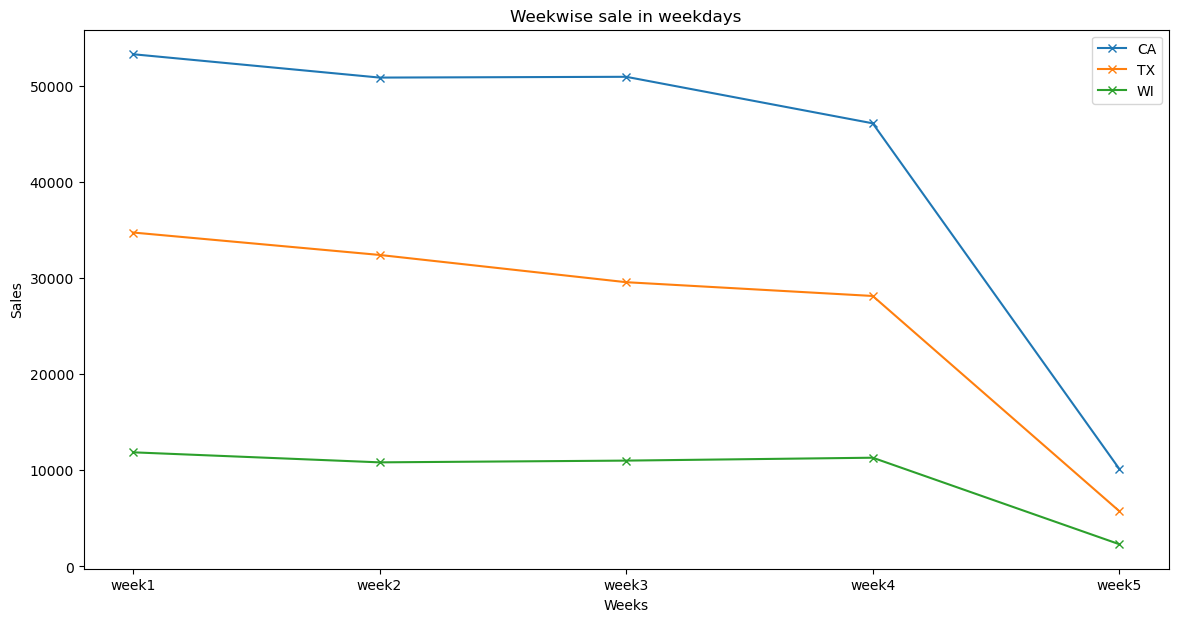

In [39]:
plt.figure(figsize=(14,7))
plt.title("Weekwise sale in weekdays")
for state in states:
    plt.plot(august_weekday_days['week'],august_weekday_days[state]/5,marker='x',linestyle='-')
label = [(str(state)) for state,c in zip(states,color[:len(states)])]
plt.legend(label,loc='upper right')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.xticks(range(27,32),['week1','week2','week3','week4','week5'])
plt.show()

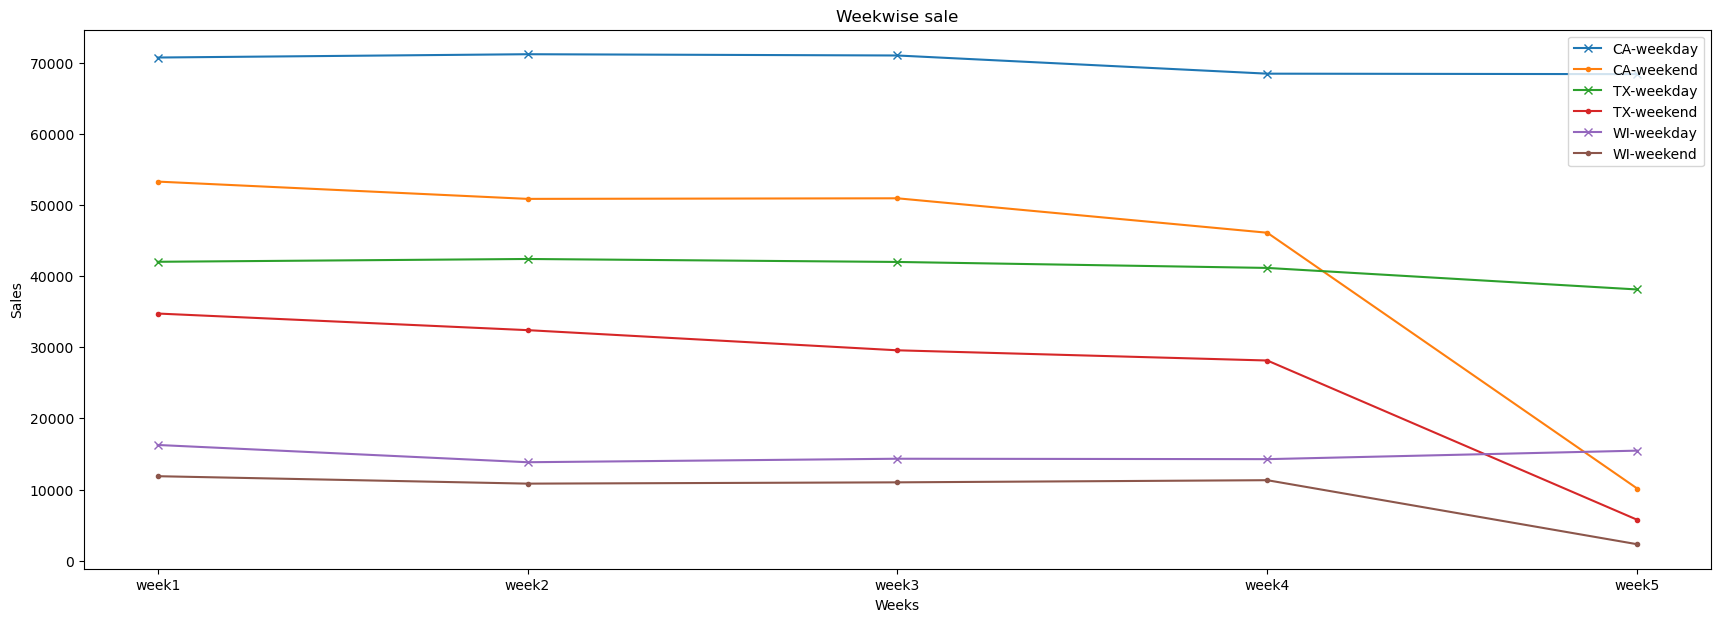

In [40]:
plt.figure(figsize=(21,7))
plt.title("Weekwise sale")
for state in states:
    plt.plot(august_weekend_days['week'],august_weekend_days[state]/2,marker='x',linestyle='-')
    plt.plot(august_weekday_days['week'],august_weekday_days[state]/5,marker='.',linestyle='-')
states_new = ['CA-weekday','CA-weekend','TX-weekday','TX-weekend','WI-weekday','WI-weekend']
label = [(str(state)) for state,c in zip(states_new,color[:len(states_new)])]
plt.legend(label,loc='upper right')
plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.xticks(range(27,32),['week1','week2','week3','week4','week5'])
plt.show()


In [41]:
type(event_data['date'])

pandas.core.series.Series

In [42]:
calendar_data.columns

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'week'],
      dtype='object')

In [43]:
event_data_2015 = event_data
event_data_2015 = event_data_2015[event_data_2015['date'].str.startswith('2015')]
event_data_2015['event_name_1']

0            Easter
1        Pesach End
2    OrthodoxEaster
3     Cinco De Mayo
4      Mother's day
5       MemorialDay
6    NBAFinalsStart
7      NBAFinalsEnd
8    Ramadan starts
9      Father's day
Name: event_name_1, dtype: object

# Comparing sales on holidays and 3 days adjacent to holidays in 2015

In [44]:
dates_2015 = []
for x in event_data_2015['date']:
    new = str(x)
    if new[0:4] == '2015':
        dates_2015.append(x)
dates_2015
len(dates_2015)

10

In [45]:
x= 0
for d in sales_2015['date']:
    if d in dates_2015:
        x+=1
dates_2015

['2015-04-05',
 '2015-04-11',
 '2015-04-12',
 '2015-05-05',
 '2015-05-10',
 '2015-05-25',
 '2015-06-04',
 '2015-06-16',
 '2015-06-18',
 '2015-06-21']

In [46]:
sales_2015_holiday = sales_2015
new  = []
sales_2015_holiday = pd.merge(sales_2015,event_data_2015,on = 'date')
for date in sales_2015_holiday['date']:
    
    new.append(date)
new
sales_2015_holiday

,Total,CA,TX,WI,date,year,month,week,FOODS,HOBBIES,...,event_name_1_y,event_type_1_y,event_name_2_y,event_type_2_y,snap_CA_y,snap_TX_y,snap_WI_y,Unnamed: 0,event_name_1,event_type_1
0,113667.53,60687.96,42124.89,10854.68,2015-04-05,2015,4.0,10,60038.73,15881.93,...,Easter,Cultural,NaN,NaN,1,1,1,0,Easter,Cultural
1,116883.65,58797.29,41655.96,16430.40,2015-04-11,2015,4.0,11,59247.83,18261.72,...,Pesach End,Religious,NaN,NaN,0,1,1,1,Pesach End,Religious
2,125350.15,64505.08,45454.37,15390.70,2015-04-12,2015,4.0,11,65978.45,18528.02,...,OrthodoxEaster,Religious,NaN,NaN,0,1,1,2,OrthodoxEaster,Religious
3,87774.47,45640.75,31074.74,11058.98,2015-05-05,2015,5.0,14,48350.36,13236.73,...,Cinco De Mayo,Cultural,NaN,NaN,1,1,1,3,Cinco De Mayo,Cultural
4,101291.50,52586.33,36789.52,11915.65,2015-05-10,2015,5.0,15,54277.57,14474.66,...,Mother's day,Cultural,NaN,NaN,1,0,0,4,Mother's day,Cultural
5,105770.13,58211.80,35102.36,12455.97,2015-05-25,2015,5.0,17,54379.54,16936.24,...,MemorialDay,National,NaN,NaN,0,0,0,5,MemorialDay,National
6,88868.59,46966.77,30324.24,11577.58,2015-06-04,2015,6.0,18,46037.62,14376.89,...,NBAFinalsStart,Sporting,NaN,NaN,1,0,0,6,NBAFinalsStart,Sporting
7,78715.46,45129.90,23148.94,10436.62,2015-06-16,2015,6.0,20,41483.78,12499.06,...,NBAFinalsEnd,Sporting,NaN,NaN,0,0,0,7,NBAFinalsEnd,Sporting
8,86611.35,47184.04,28389.00,11038.31,2015-06-18,2015,6.0,20,44769.70,13126.44,...,Ramadan starts,Religious,NaN,NaN,0,0,0,8,Ramadan starts,Religious
9,105292.42,57200.57,35808.01,12283.84,2015-06-21,2015,6.0,21,54295.57,16089.69,...,Father's day,Cultural,NaN,NaN,0,0,0,9,Father's day,Cultural


In [47]:
sales_2015.columns

Index(['Total', 'CA', 'TX', 'WI', 'date', 'year', 'month', 'week', 'FOODS',
       'HOBBIES',
       ...
       'weekday', 'wday', 'd', 'event_name_1_y', 'event_type_1_y',
       'event_name_2_y', 'event_type_2_y', 'snap_CA_y', 'snap_TX_y',
       'snap_WI_y'],
      dtype='object', length=146)

In [48]:
holidays = []
for hol in event_data_2015['event_name_1']:
    if hol:
        x = str(hol)
        holidays.append(x)
holidays

['Easter',
 'Pesach End',
 'OrthodoxEaster',
 'Cinco De Mayo',
 "Mother's day",
 'MemorialDay',
 'NBAFinalsStart',
 'NBAFinalsEnd',
 'Ramadan starts',
 "Father's day"]

In [49]:
sales_2015_holiday['week'] = [float(w) for w in sales_2015_holiday['week']]
sales_2015_holiday['week']

0    10.0
1    11.0
2    11.0
3    14.0
4    15.0
5    17.0
6    18.0
7    20.0
8    20.0
9    21.0
Name: week, dtype: float64

In [50]:
sales_2015_holiday = pd.merge(sales_2015, sales_2015_holiday, on='week')
sales_2015_holiday = sales_2015_holiday.select_dtypes(include=['float64','float32'])
sales_2015_holiday

,Total_x,CA_x,TX_x,WI_x,month_x,FOODS_x,HOBBIES_x,HOUSEHOLD_x,CA_1_x,CA_2_x,...,HOUSEHOLD2CA1_y,HOUSEHOLD2CA2_y,HOUSEHOLD2CA3_y,HOUSEHOLD2CA4_y,HOUSEHOLD2TX1_y,HOUSEHOLD2TX2_y,HOUSEHOLD2TX3_y,HOUSEHOLD2WI1_y,HOUSEHOLD2WI2_y,HOUSEHOLD2WI3_y
0,125804.04,66751.14,41866.37,17186.53,4.0,66658.69,19801.31,39344.04,20302.95,11342.13,...,1247.67,1880.84,2554.43,720.37,1071.40,1178.53,758.83,667.41,0.0,0.0
1,113667.53,60687.96,42124.89,10854.68,4.0,60038.73,15881.93,37746.87,15554.50,10814.77,...,1247.67,1880.84,2554.43,720.37,1071.40,1178.53,758.83,667.41,0.0,0.0
2,95258.05,48153.45,36801.73,10302.87,4.0,49825.46,15249.02,30183.57,13058.59,7677.56,...,1247.67,1880.84,2554.43,720.37,1071.40,1178.53,758.83,667.41,0.0,0.0
3,88738.86,45382.24,33664.45,9692.17,4.0,46918.68,14443.87,27376.31,12178.06,6567.30,...,1247.67,1880.84,2554.43,720.37,1071.40,1178.53,758.83,667.41,0.0,0.0
4,87303.20,45577.13,30896.04,10830.03,4.0,45853.58,14009.16,27440.46,12195.60,6912.01,...,1247.67,1880.84,2554.43,720.37,1071.40,1178.53,758.83,667.41,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,89464.05,49537.70,29859.39,10066.96,6.0,44788.52,14807.03,29868.50,12980.23,9304.22,...,1202.80,2275.30,2050.90,580.42,823.89,901.86,747.98,889.30,0.0,0.0
66,84170.78,45770.77,27820.71,10579.30,6.0,42296.39,13790.17,28084.22,12571.78,9204.05,...,1202.80,2275.30,2050.90,580.42,823.89,901.86,747.98,889.30,0.0,0.0
67,81246.72,43084.76,28012.31,10149.65,6.0,41021.85,13819.49,26405.38,11594.17,9074.10,...,1202.80,2275.30,2050.90,580.42,823.89,901.86,747.98,889.30,0.0,0.0
68,81510.21,44575.93,26840.65,10093.63,6.0,42297.04,12946.32,26266.85,11410.05,9335.02,...,1202.80,2275.30,2050.90,580.42,823.89,901.86,747.98,889.30,0.0,0.0


In [51]:
date_trim_data['date'] = pd.to_datetime(date_trim_data['date'])
date_trim_data[date_trim_data['wday'] == 3]

,Total,CA,TX,WI,date,year,month,week,FOODS,HOBBIES,...,weekday,wday,d,event_name_1_y,event_type_1_y,event_name_2_y,event_type_2_y,snap_CA_y,snap_TX_y,snap_WI_y
2,46430.26,25283.73,16609.83,4536.70,2011-01-31,2011,1,1,27147.85,6109.06,...,Monday,3,d_3,NaN,NaN,NaN,NaN,0,0,0
9,53402.91,29617.30,19250.88,4534.73,2011-02-07,2011,2,2,33474.65,6028.98,...,Monday,3,d_10,NaN,NaN,NaN,NaN,1,1,0
16,48969.48,25228.22,18626.73,5114.53,2011-02-14,2011,2,3,30009.98,5825.96,...,Monday,3,d_17,ValentinesDay,Cultural,NaN,NaN,0,0,1
23,56088.34,33537.37,19361.78,3189.19,2011-02-21,2011,2,4,31143.61,6517.16,...,Monday,3,d_24,PresidentsDay,National,NaN,NaN,0,0,0
30,48515.68,25737.22,18052.46,4726.00,2011-02-28,2011,2,5,27737.25,5660.96,...,Monday,3,d_31,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1878,99120.99,54337.57,32790.04,11993.38,2016-03-21,2016,3,8,52668.63,14818.73,...,Monday,3,d_1879,NaN,NaN,NaN,NaN,0,0,0
1885,96256.59,50438.11,33799.97,12018.51,2016-03-28,2016,3,9,50258.19,15074.55,...,Monday,3,d_1886,NaN,NaN,NaN,NaN,0,0,0
1892,106578.51,60603.83,34003.75,11970.93,2016-04-04,2016,4,10,57360.09,15250.75,...,Monday,3,d_1893,NaN,NaN,NaN,NaN,1,0,0
1899,106741.54,57641.55,36510.12,12589.87,2016-04-11,2016,4,11,58217.70,14894.54,...,Monday,3,d_1900,NaN,NaN,NaN,NaN,0,1,1


In [52]:
m = Prophet()
texas_predictor = date_trim_data[['date','TX']]
texas_predictor.rename(columns={'date': 'ds'}, inplace=True)
texas_predictor.rename(columns={'TX': 'y'}, inplace=True)
texas_predictor

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\1290901659.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texas_predictor.rename(columns={'date': 'ds'}, inplace=True)
C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\1290901659.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texas_predictor.rename(columns={'TX': 'y'}, inplace=True)


,ds,y
0,2011-01-29,24100.45
1,2011-01-30,23771.68
2,2011-01-31,16609.83
3,2011-02-01,17957.96
4,2011-02-02,14455.86
...,...,...
1908,2016-04-20,31321.65
1909,2016-04-21,31205.16
1910,2016-04-22,33884.35
1911,2016-04-23,39042.59


In [53]:
m.fit(texas_predictor)

12:00:16 - cmdstanpy - INFO - Chain [1] start processing
12:00:17 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
future = m.make_future_dataframe(periods=245)
future.tail()

,ds
2153,2016-12-21
2154,2016-12-22
2155,2016-12-23
2156,2016-12-24
2157,2016-12-25


In [55]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2153,2016-12-21,32750.491004,29181.236002,36501.992448
2154,2016-12-22,32866.918946,29024.397330,36681.984723
2155,2016-12-23,35310.784334,31587.796575,38882.730516
2156,2016-12-24,41193.143472,37340.265807,44953.336940
2157,2016-12-25,42841.474357,39144.358333,46327.935115


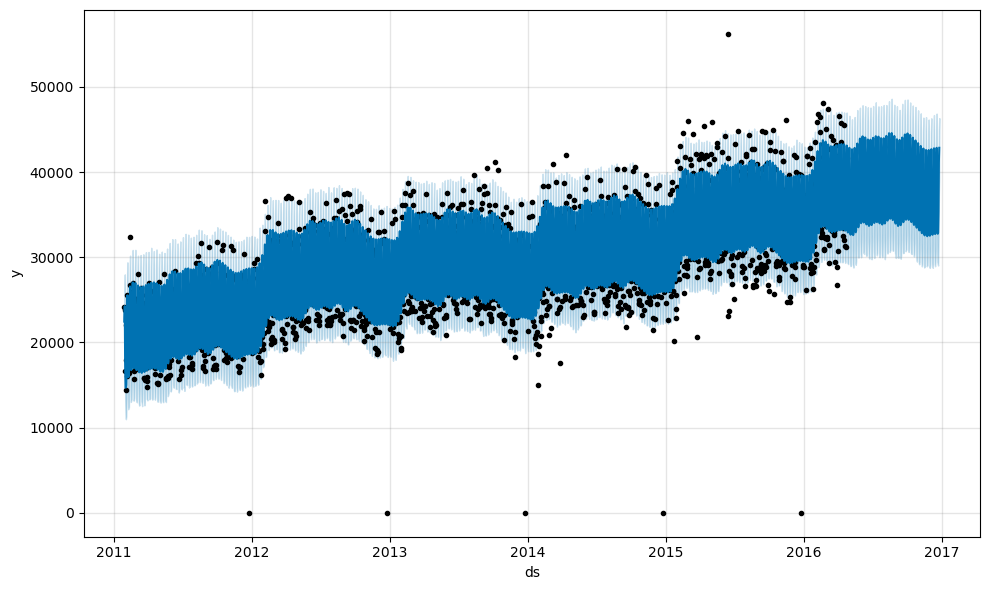

In [56]:
fig1 = m.plot(forecast)

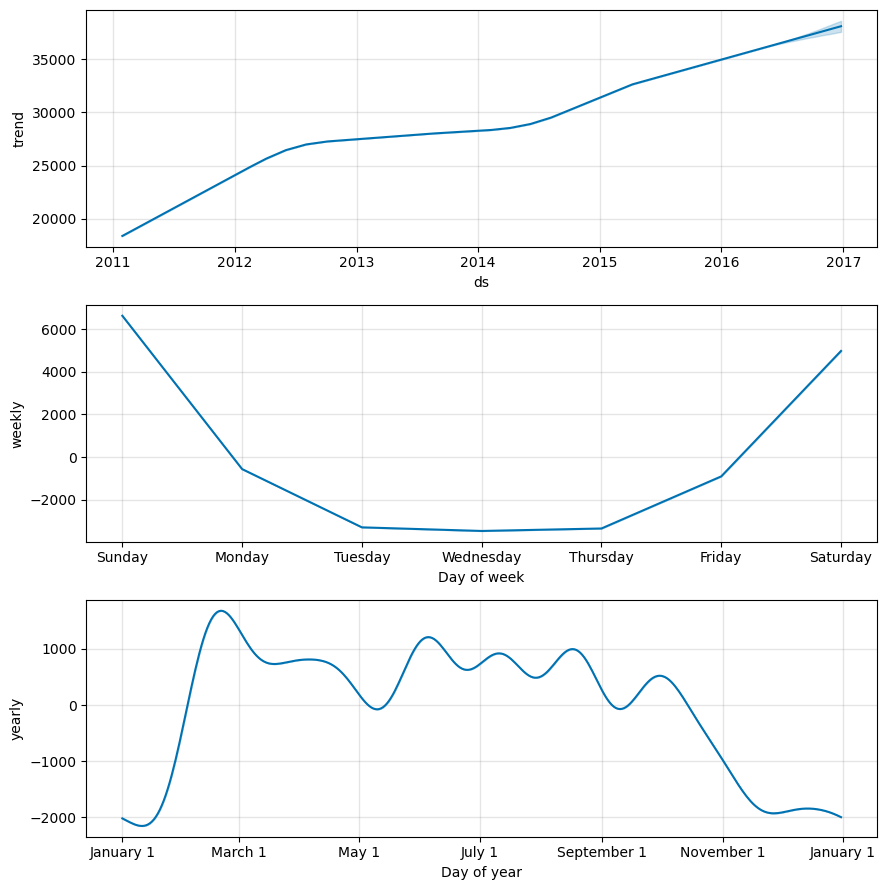

In [57]:
fig2 = m.plot_components(forecast)

In [58]:
k = Prophet()
cal_predictor = date_trim_data[['date','CA']]
cal_predictor.rename(columns={'date': 'ds'}, inplace=True)
cal_predictor.rename(columns={'CA': 'y'}, inplace=True)
cal_predictor

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\2389974567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal_predictor.rename(columns={'date': 'ds'}, inplace=True)
C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\2389974567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal_predictor.rename(columns={'CA': 'y'}, inplace=True)


,ds,y
0,2011-01-29,36276.10
1,2011-01-30,35047.46
2,2011-01-31,25283.73
3,2011-02-01,26917.00
4,2011-02-02,25175.63
...,...,...
1908,2016-04-20,50003.75
1909,2016-04-21,46834.62
1910,2016-04-22,55652.00
1911,2016-04-23,72937.13


In [59]:
k.fit(cal_predictor)

12:00:18 - cmdstanpy - INFO - Chain [1] start processing
12:00:19 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
future = k.make_future_dataframe(periods=245)
future.tail()

,ds
2153,2016-12-21
2154,2016-12-22
2155,2016-12-23
2156,2016-12-24
2157,2016-12-25


In [61]:
forecast = k.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2153,2016-12-21,53553.199959,48269.721880,58822.621112
2154,2016-12-22,53467.687165,48094.640001,58969.311884
2155,2016-12-23,58333.228152,53319.809925,63533.134987
2156,2016-12-24,69015.852073,63943.695665,74397.761160
2157,2016-12-25,70451.388258,64788.442723,75978.931919


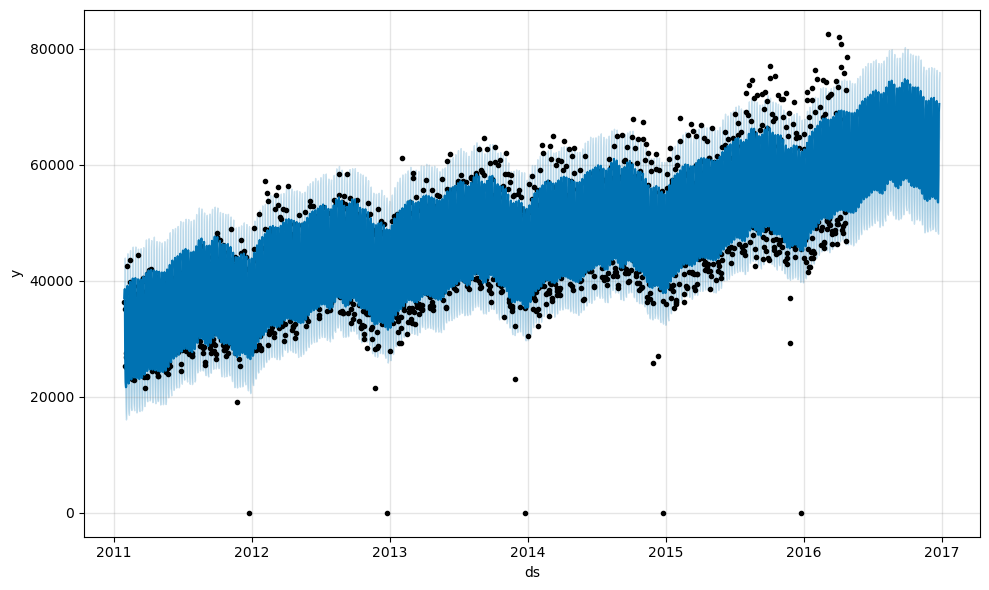

In [62]:
fig1 = k.plot(forecast)

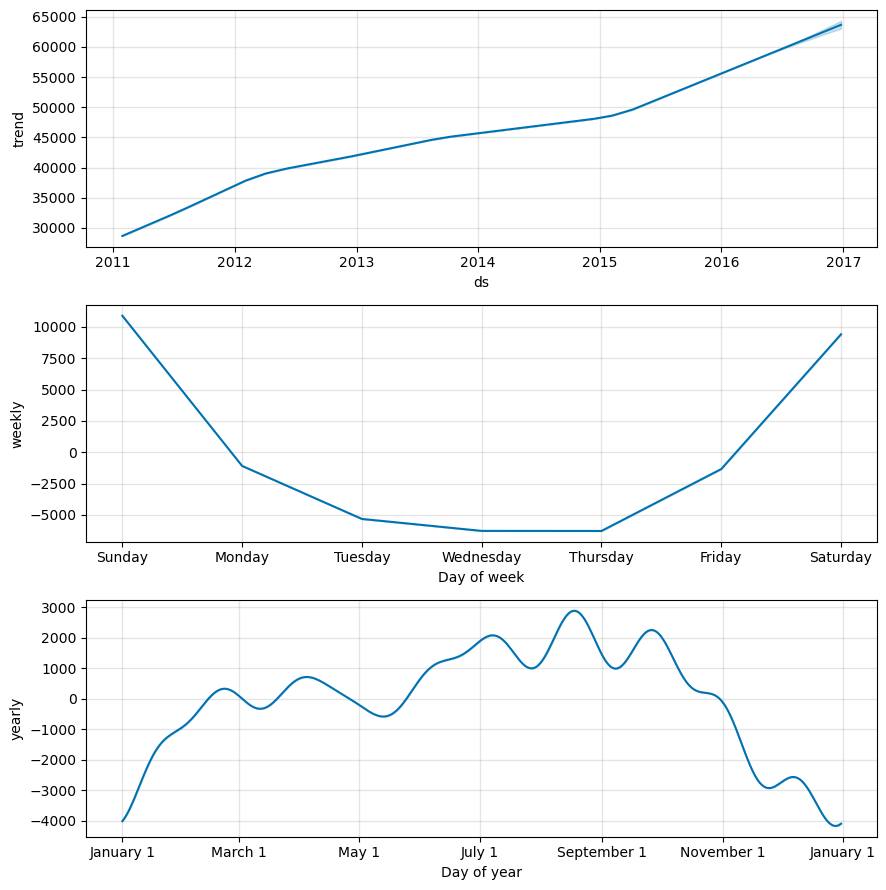

In [63]:
fig2 = k.plot_components(forecast)

In [64]:
w = Prophet()
wisconsin_predictor = date_trim_data[['date','WI']]
wisconsin_predictor.rename(columns={'date': 'ds'}, inplace=True)
wisconsin_predictor.rename(columns={'WI': 'y'}, inplace=True)
wisconsin_predictor

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\2795823639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wisconsin_predictor.rename(columns={'date': 'ds'}, inplace=True)
C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\2795823639.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wisconsin_predictor.rename(columns={'WI': 'y'}, inplace=True)


,ds,y
0,2011-01-29,7520.13
1,2011-01-30,6577.80
2,2011-01-31,4536.70
3,2011-02-01,3906.43
4,2011-02-02,324.23
...,...,...
1908,2016-04-20,12181.79
1909,2016-04-21,12573.31
1910,2016-04-22,14788.45
1911,2016-04-23,17316.81


In [65]:
w.fit(wisconsin_predictor)

12:00:20 - cmdstanpy - INFO - Chain [1] start processing
12:00:20 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
future = w.make_future_dataframe(periods=245)
future.tail()

,ds
2153,2016-12-21
2154,2016-12-22
2155,2016-12-23
2156,2016-12-24
2157,2016-12-25


In [67]:
forecast = w.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2153,2016-12-21,13387.955394,11694.974156,15216.822141
2154,2016-12-22,13418.105523,11582.420405,15213.622134
2155,2016-12-23,15158.509940,13343.245714,16890.648270
2156,2016-12-24,17493.248947,15548.325587,19358.494279
2157,2016-12-25,15890.732153,14094.308001,17725.020392


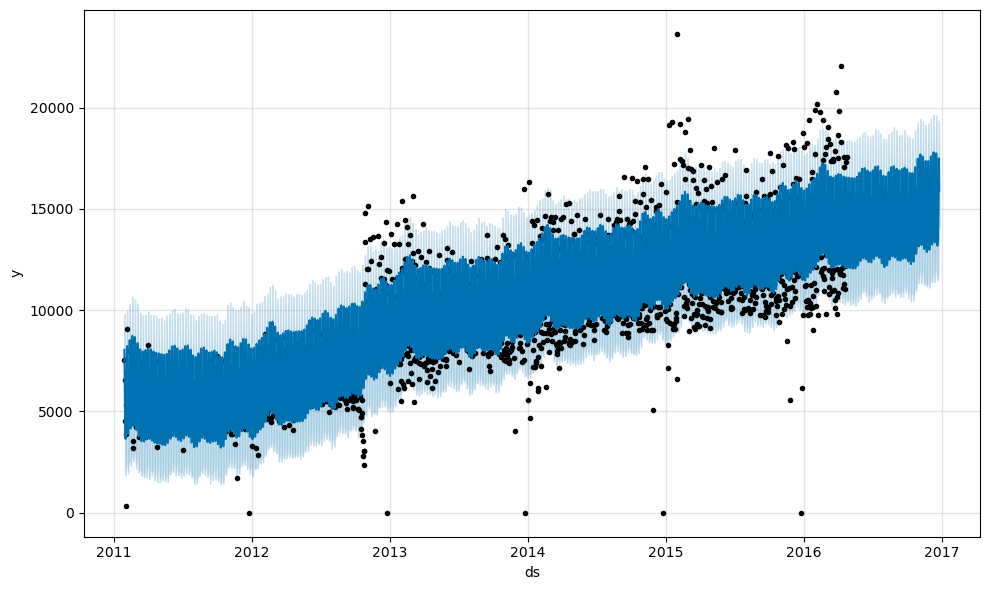

In [68]:
fig1 = w.plot(forecast)

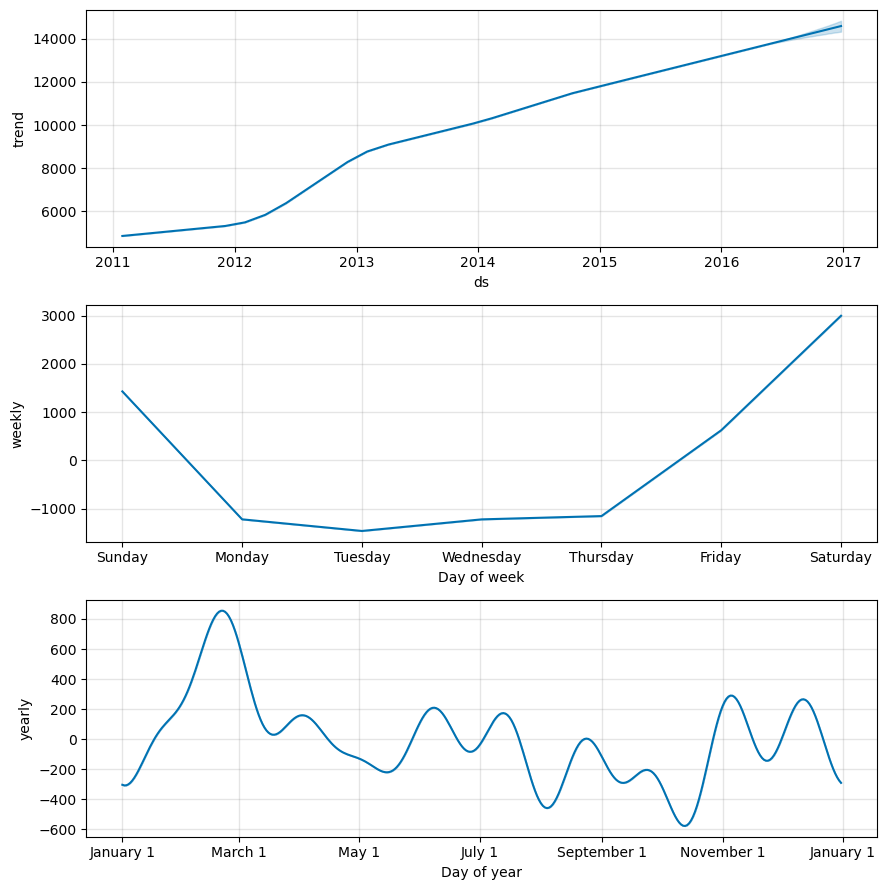

In [69]:
fig2 = w.plot_components(forecast)

In [70]:
t = Prophet()
total_predictor = date_trim_data[['date','Total']]
total_predictor.rename(columns={'date': 'ds'}, inplace=True)
total_predictor.rename(columns={'Total': 'y'}, inplace=True)
total_predictor

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\2509119946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_predictor.rename(columns={'date': 'ds'}, inplace=True)
C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\2509119946.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_predictor.rename(columns={'Total': 'y'}, inplace=True)


,ds,y
0,2011-01-29,67896.68
1,2011-01-30,65396.94
2,2011-01-31,46430.26
3,2011-02-01,48781.39
4,2011-02-02,39955.72
...,...,...
1908,2016-04-20,93507.19
1909,2016-04-21,90613.09
1910,2016-04-22,104324.80
1911,2016-04-23,129296.53


In [71]:
t.fit(total_predictor)

12:00:22 - cmdstanpy - INFO - Chain [1] start processing
12:00:22 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
future = t.make_future_dataframe(periods=245)
future.tail()

,ds
2153,2016-12-21
2154,2016-12-22
2155,2016-12-23
2156,2016-12-24
2157,2016-12-25


In [73]:
forecast = t.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2153,2016-12-21,98648.656928,89565.993275,108049.590150
2154,2016-12-22,98707.325207,89199.748716,108518.272647
2155,2016-12-23,107754.527964,97647.596372,117717.548059
2156,2016-12-24,126651.872412,116917.917542,136900.771595
2157,2016-12-25,128130.647834,118549.636852,137687.734065


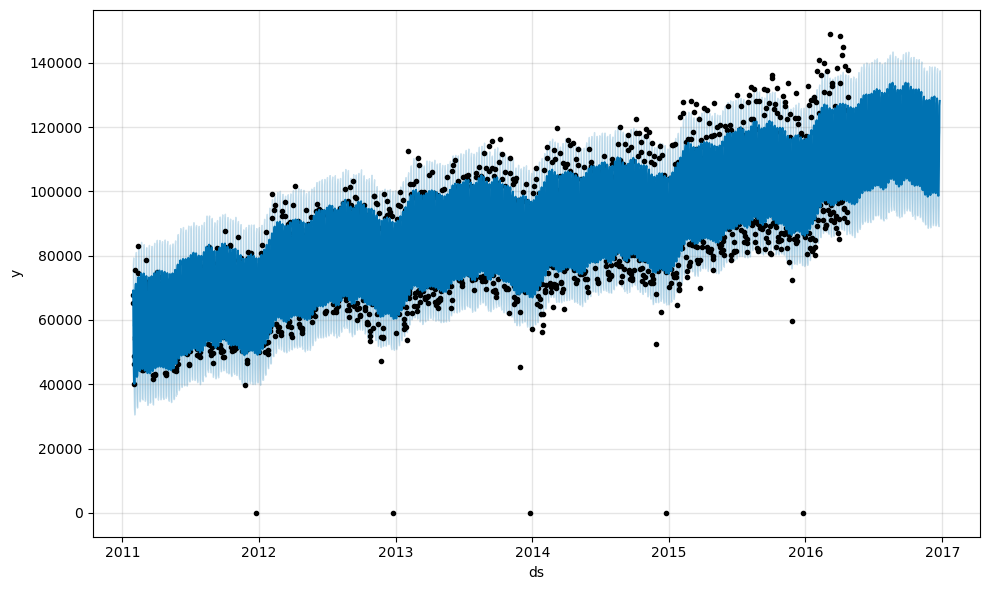

In [74]:
fig1 = t.plot(forecast)

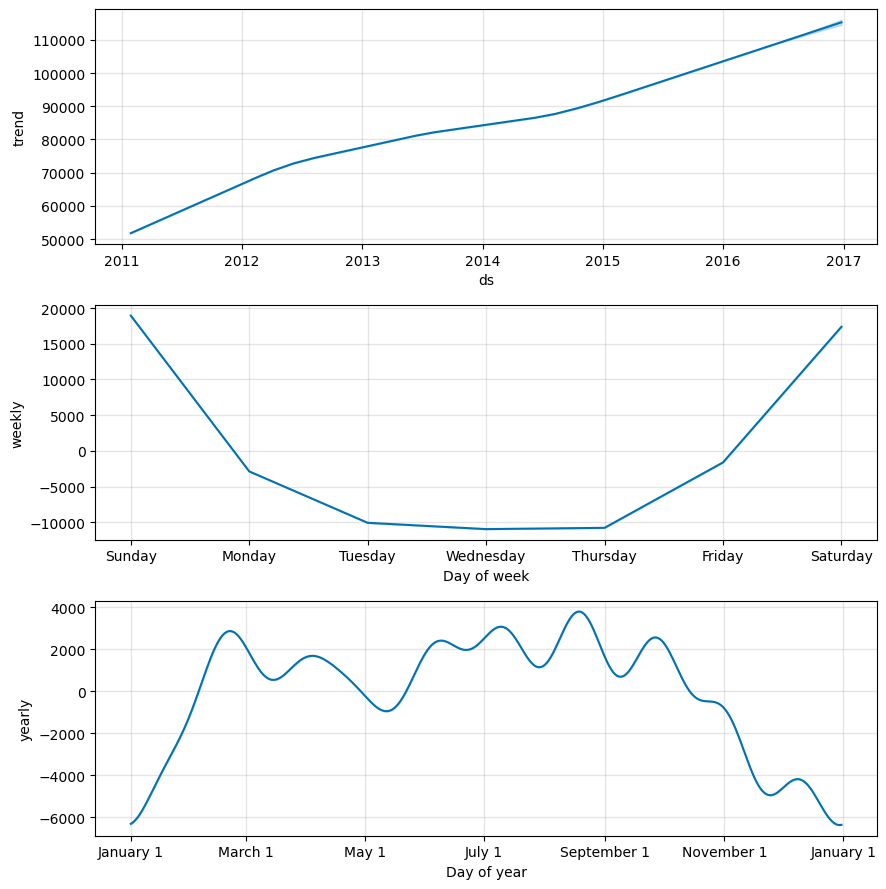

In [75]:
fig2 = t.plot_components(forecast)

In [113]:
accepted_data = date_trim_data[date_trim_data['Total']>1000]
training_data = date_trim_data.iloc[:1500,:]
testing_data = date_trim_data.iloc[1500:,:]
testing_data

,Total,CA,TX,WI,date,year,month,week,FOODS,HOBBIES,...,weekday,wday,d,event_name_1_y,event_type_1_y,event_name_2_y,event_type_2_y,snap_CA_y,snap_TX_y,snap_WI_y
1500,92230.00,47445.65,32910.22,11874.13,2015-03-09,2015,3,6,50627.44,13493.40,...,Monday,3,d_1501,NaN,NaN,NaN,NaN,1,1,1
1501,89348.92,44107.90,35618.40,9622.62,2015-03-10,2015,3,6,46527.59,13896.02,...,Tuesday,4,d_1502,NaN,NaN,NaN,NaN,1,0,0
1502,83112.06,41495.68,31253.10,10363.28,2015-03-11,2015,3,6,44354.09,13138.33,...,Wednesday,5,d_1503,NaN,NaN,NaN,NaN,0,1,1
1503,84818.73,41338.28,32674.25,10806.20,2015-03-12,2015,3,6,45083.26,13999.22,...,Thursday,6,d_1504,NaN,NaN,NaN,NaN,0,1,1
1504,94359.83,46308.62,36122.17,11929.04,2015-03-13,2015,3,6,49750.33,14522.28,...,Friday,7,d_1505,NaN,NaN,NaN,NaN,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,93507.19,50003.75,31321.65,12181.79,2016-04-20,2016,4,12,50334.45,14360.80,...,Wednesday,5,d_1909,NaN,NaN,NaN,NaN,0,0,0
1909,90613.09,46834.62,31205.16,12573.31,2016-04-21,2016,4,12,49017.95,13395.77,...,Thursday,6,d_1910,NaN,NaN,NaN,NaN,0,0,0
1910,104324.80,55652.00,33884.35,14788.45,2016-04-22,2016,4,12,55480.95,15467.42,...,Friday,7,d_1911,NaN,NaN,NaN,NaN,0,0,0
1911,129296.53,72937.13,39042.59,17316.81,2016-04-23,2016,4,13,66564.98,19746.70,...,Saturday,1,d_1912,NaN,NaN,NaN,NaN,0,0,0


In [114]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=training_data["date"], y=training_data["Total"],
                     mode="lines", name="sales", line=dict(color="blue")), row=1, col=1)

In [136]:
new = Prophet(daily_seasonality = True)
test_predictor = training_data[['date','Total']]
test_predictor.rename(columns={'date': 'ds'}, inplace=True)
test_predictor.rename(columns={'Total': 'y'}, inplace=True)
new.fit(test_predictor)
future = new.make_future_dataframe(periods=413)
forecast = new.predict(future)
predicted_data = forecast[['ds','yhat']]
predicted_data = predicted_data.iloc[1500:,:]
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=date_trim_data["date"], y=date_trim_data["Total"],
                     mode="lines", name="sales", line=dict(color="blue")), row=1, col=1)
fig.add_trace(go.Scatter(x=predicted_data["ds"], y=predicted_data["yhat"],
                     mode="lines", name="sales predicted", line=dict(color="red")), row=1, col=1)

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\2152328054.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\2152328054.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

12:16:51 - cmdstanpy - INFO - Chain [1] start processing
12:16:51 - cmdstanpy - INFO - Chain [1] done processing


In [137]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
df_cv = cross_validation(new, initial='750 days', period='120 days', horizon = '365 days',parallel="processes")
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,3.810952e+07,6173.291214,4585.728975,0.057657,0.047167,0.056062,0.893836
1,38 days,3.725680e+07,6103.834741,4550.505850,0.057556,0.046871,0.055926,0.890411
2,39 days,3.772515e+07,6142.080072,4594.996375,0.058244,0.048774,0.056616,0.883562
3,40 days,3.775299e+07,6144.346427,4586.259326,0.058323,0.048374,0.056662,0.883562
4,41 days,3.866274e+07,6217.936588,4647.388071,0.058986,0.049653,0.057375,0.876712
...,...,...,...,...,...,...,...,...
324,361 days,7.256570e+07,8518.550361,6741.351909,0.075399,0.070893,0.075091,0.654110
325,362 days,7.214319e+07,8493.714811,6726.613657,0.075288,0.070893,0.075050,0.654110
326,363 days,7.187701e+07,8478.031276,6736.671399,0.075290,0.070893,0.075109,0.657534
327,364 days,7.320753e+07,8556.139929,6798.178216,0.075592,0.070893,0.075470,0.654110


In [138]:
from prophet.diagnostics import performance_metrics
cutoffs = pd.to_datetime(['2011-08-15','2012-02-15','2012-08-15','2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(new, initial='100 days', cutoffs=cutoffs , period='10 days', horizon='30 days')
df_p = performance_metrics(df_cv)
df_p

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/6 [00:00<?, ?it/s]

12:16:55 - cmdstanpy - INFO - Chain [1] start processing
12:16:55 - cmdstanpy - INFO - Chain [1] done processing
12:16:55 - cmdstanpy - INFO - Chain [1] start processing
12:16:55 - cmdstanpy - INFO - Chain [1] done processing
12:16:55 - cmdstanpy - INFO - Chain [1] start processing
12:16:55 - cmdstanpy - INFO - Chain [1] done processing
12:16:55 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] done processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] done processing
12:16:56 - cmdstanpy - INFO - Chain [1] start processing
12:16:56 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,3.810952e+07,6173.291214,4585.728975,0.057657,0.047167,0.056062,0.893836
1,38 days,3.725680e+07,6103.834741,4550.505850,0.057556,0.046871,0.055926,0.890411
2,39 days,3.772515e+07,6142.080072,4594.996375,0.058244,0.048774,0.056616,0.883562
3,40 days,3.775299e+07,6144.346427,4586.259326,0.058323,0.048374,0.056662,0.883562
4,41 days,3.866274e+07,6217.936588,4647.388071,0.058986,0.049653,0.057375,0.876712
...,...,...,...,...,...,...,...,...
324,361 days,7.256570e+07,8518.550361,6741.351909,0.075399,0.070893,0.075091,0.654110
325,362 days,7.214319e+07,8493.714811,6726.613657,0.075288,0.070893,0.075050,0.654110
326,363 days,7.187701e+07,8478.031276,6736.671399,0.075290,0.070893,0.075109,0.657534
327,364 days,7.320753e+07,8556.139929,6798.178216,0.075592,0.070893,0.075470,0.654110


In [164]:
new = Prophet(daily_seasonality = True, yearly_seasonality=24, seasonality_mode = 'multiplicative')
test_predictor = date_trim_data[['date','Total']]
for i in range(len(test_predictor)):
    if(test_predictor['Total'][i] < 1000):
        test_predictor['Total'][i] = (test_predictor['Total'][i-1] + test_predictor['Total'][i+1])/2
test_predictor = test_predictor.iloc[:1750,:]
test_predictor.rename(columns={'date': 'ds'}, inplace=True)
test_predictor.rename(columns={'Total': 'y'}, inplace=True)
new.fit(test_predictor)
future = new.make_future_dataframe(periods=163)
forecast = new.predict(future)
predicted_data = forecast[['ds','yhat']]
predicted_data = predicted_data.iloc[1750:,:]
test_predictor = date_trim_data[['date','Total']]
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=test_predictor["date"], y=test_predictor["Total"],
                     mode="lines", name="sales", line=dict(color="blue")), row=1, col=1)
fig.add_trace(go.Scatter(x=predicted_data["ds"], y=predicted_data["yhat"],
                     mode="lines", name="sales predicted", line=dict(color="red")), row=1, col=1)

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\3696651802.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

12:32:57 - cmdstanpy - INFO - Chain [1] start processing
12:32:57 - cmdstanpy - INFO - Chain [1] done processing


In [165]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
df_cv = cross_validation(new, initial='750 days', period='120 days', horizon = '365 days',parallel="processes")
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,3.933224e+07,6271.542149,4403.342831,0.053382,0.036634,0.053313,0.737443
1,38 days,3.988105e+07,6315.144733,4464.141397,0.054003,0.037663,0.053967,0.730594
2,39 days,4.107716e+07,6409.146967,4548.541551,0.054725,0.038283,0.054741,0.723744
3,40 days,4.318514e+07,6571.540376,4696.502268,0.056237,0.039662,0.056290,0.710046
4,41 days,4.460267e+07,6678.522761,4743.437978,0.056835,0.039514,0.056748,0.712329
...,...,...,...,...,...,...,...,...
324,361 days,6.577025e+07,8109.886145,6314.608752,0.066752,0.058628,0.067338,0.691781
325,362 days,6.675984e+07,8170.669350,6374.103174,0.067405,0.058526,0.068025,0.687215
326,363 days,6.556967e+07,8097.510139,6323.099331,0.067162,0.058951,0.067744,0.691781
327,364 days,6.526591e+07,8078.731773,6309.191315,0.067119,0.058951,0.067720,0.703196


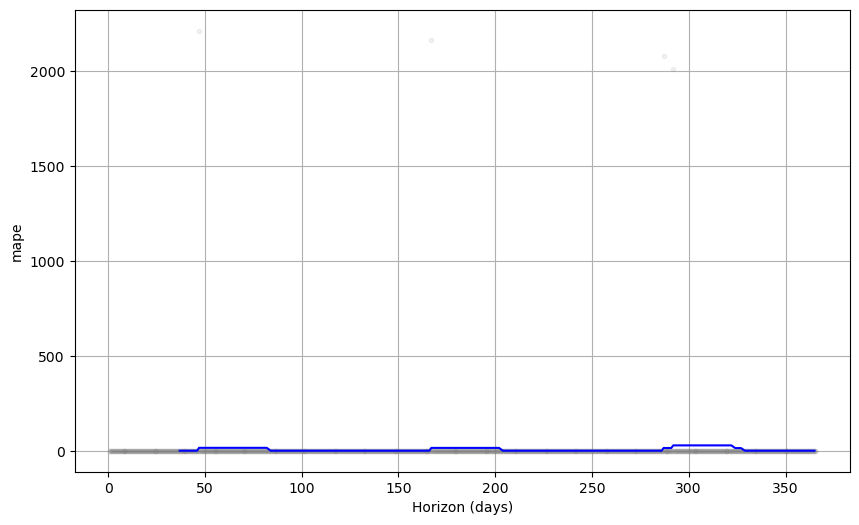

In [139]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [87]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_range' : [0.8, 0.9],
    #'weekly_seasonality' : [True,False]
}

rmses = []
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]


# Use cross validation to evaluate all parameters
for params in all_params:
    new = Prophet(**params).fit(test_predictor)  # Fit model with given params
    df_cv = cross_validation(new, initial='750 days', period='120 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['mape'].values[0])

#Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)


12:00:32 - cmdstanpy - INFO - Chain [1] start processing
12:00:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:34 - cmdstanpy - INFO - Chain [1] start processing
12:00:34 - cmdstanpy - INFO - Chain [1] done processing
12:00:35 - cmdstanpy - INFO - Chain [1] start processing
12:00:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:35 - cmdstanpy - INFO - Chain [1] start processing
12:00:35 - cmdstanpy - INFO - Chain [1] done processing
12:00:35 - cmdstanpy - INFO - Chain [1] start processing
12:00:35 - cmdstanpy - INFO - Chain [1] done processing
12:00:36 - cmdstanpy - INFO - Chain [1] start processing
12:00:36 - cmdstanpy - INFO - Chain [1] done processing
12:00:36 - cmdstanpy - INFO - Chain [1] start processing
12:00:36 - cmdstanpy - INFO - Chain [1] done processing
12:00:37 - cmdstanpy - INFO - Chain [1] start processing
12:00:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:37 - cmdstanpy - INFO - Chain [1] start processing
12:00:37 - cmdstanpy - INFO - Chain [1] done processing
12:00:37 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:39 - cmdstanpy - INFO - Chain [1] start processing
12:00:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:39 - cmdstanpy - INFO - Chain [1] start processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing
12:00:40 - cmdstanpy - INFO - Chain [1] start processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing
12:00:40 - cmdstanpy - INFO - Chain [1] start processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing
12:00:40 - cmdstanpy - INFO - Chain [1] start processing
12:00:40 - cmdstanpy - INFO - Chain [1] done processing
12:00:41 - cmdstanpy - INFO - Chain [1] start processing
12:00:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:42 - cmdstanpy - INFO - Chain [1] start processing
12:00:42 - cmdstanpy - INFO - Chain [1] done processing
12:00:42 - cmdstanpy - INFO - Chain [1] start processing
12:00:42 - cmdstanpy - INFO - Chain [1] done processing
12:00:42 - cmdstanpy - INFO - Chain [1] start processing
12:00:42 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing
12:00:44 - cmdstanpy - INFO - Chain [1] start processing
12:00:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:44 - cmdstanpy - INFO - Chain [1] start processing
12:00:44 - cmdstanpy - INFO - Chain [1] done processing
12:00:44 - cmdstanpy - INFO - Chain [1] start processing
12:00:44 - cmdstanpy - INFO - Chain [1] done processing
12:00:45 - cmdstanpy - INFO - Chain [1] start processing
12:00:45 - cmdstanpy - INFO - Chain [1] done processing
12:00:45 - cmdstanpy - INFO - Chain [1] start processing
12:00:45 - cmdstanpy - INFO - Chain [1] done processing
12:00:46 - cmdstanpy - INFO - Chain [1] start processing
12:00:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:46 - cmdstanpy - INFO - Chain [1] start processing
12:00:46 - cmdstanpy - INFO - Chain [1] done processing
12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing
12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing
12:00:47 - cmdstanpy - INFO - Chain [1] start processing
12:00:47 - cmdstanpy - INFO - Chain [1] done processing
12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:48 - cmdstanpy - INFO - Chain [1] start processing
12:00:48 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:50 - cmdstanpy - INFO - Chain [1] start processing
12:00:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:51 - cmdstanpy - INFO - Chain [1] start processing
12:00:51 - cmdstanpy - INFO - Chain [1] done processing
12:00:51 - cmdstanpy - INFO - Chain [1] start processing
12:00:51 - cmdstanpy - INFO - Chain [1] done processing
12:00:51 - cmdstanpy - INFO - Chain [1] start processing
12:00:51 - cmdstanpy - INFO - Chain [1] done processing
12:00:52 - cmdstanpy - INFO - Chain [1] start processing
12:00:52 - cmdstanpy - INFO - Chain [1] done processing
12:00:53 - cmdstanpy - INFO - Chain [1] start processing
12:00:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:53 - cmdstanpy - INFO - Chain [1] start processing
12:00:53 - cmdstanpy - INFO - Chain [1] done processing
12:00:53 - cmdstanpy - INFO - Chain [1] start processing
12:00:53 - cmdstanpy - INFO - Chain [1] done processing
12:00:54 - cmdstanpy - INFO - Chain [1] start processing
12:00:54 - cmdstanpy - INFO - Chain [1] done processing
12:00:54 - cmdstanpy - INFO - Chain [1] start processing
12:00:54 - cmdstanpy - INFO - Chain [1] done processing
12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing
12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:56 - cmdstanpy - INFO - Chain [1] done processing
12:00:56 - cmdstanpy - INFO - Chain [1] start processing
12:00:56 - cmdstanpy - INFO - Chain [1] done processing
12:00:56 - cmdstanpy - INFO - Chain [1] start processing
12:00:56 - cmdstanpy - INFO - Chain [1] done processing
12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:00:57 - cmdstanpy - INFO - Chain [1] start processing
12:00:57 - cmdstanpy - INFO - Chain [1] done processing
12:00:58 - cmdstanpy - INFO - Chain [1] start processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing
12:00:58 - cmdstanpy - INFO - Chain [1] start processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing
12:00:58 - cmdstanpy - INFO - Chain [1] start processing
12:00:58 - cmdstanpy - INFO - Chain [1] done processing
12:00:59 - cmdstanpy - INFO - Chain [1] start processing
12:00:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:00 - cmdstanpy - INFO - Chain [1] start processing
12:01:00 - cmdstanpy - INFO - Chain [1] done processing
12:01:00 - cmdstanpy - INFO - Chain [1] start processing
12:01:00 - cmdstanpy - INFO - Chain [1] done processing
12:01:00 - cmdstanpy - INFO - Chain [1] start processing
12:01:00 - cmdstanpy - INFO - Chain [1] done processing
12:01:00 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1] done processing
12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:02 - cmdstanpy - INFO - Chain [1] start processing
12:01:02 - cmdstanpy - INFO - Chain [1] done processing
12:01:02 - cmdstanpy - INFO - Chain [1] start processing
12:01:02 - cmdstanpy - INFO - Chain [1] done processing
12:01:02 - cmdstanpy - INFO - Chain [1] start processing
12:01:02 - cmdstanpy - INFO - Chain [1] done processing
12:01:03 - cmdstanpy - INFO - Chain [1] start processing
12:01:03 - cmdstanpy - INFO - Chain [1] done processing
12:01:04 - cmdstanpy - INFO - Chain [1] start processing
12:01:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:04 - cmdstanpy - INFO - Chain [1] start processing
12:01:04 - cmdstanpy - INFO - Chain [1] done processing
12:01:04 - cmdstanpy - INFO - Chain [1] start processing
12:01:04 - cmdstanpy - INFO - Chain [1] done processing
12:01:04 - cmdstanpy - INFO - Chain [1] start processing
12:01:05 - cmdstanpy - INFO - Chain [1] done processing
12:01:05 - cmdstanpy - INFO - Chain [1] start processing
12:01:05 - cmdstanpy - INFO - Chain [1] done processing
12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing
12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:08 - cmdstanpy - INFO - Chain [1] start processing
12:01:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:08 - cmdstanpy - INFO - Chain [1] start processing
12:01:09 - cmdstanpy - INFO - Chain [1] done processing
12:01:09 - cmdstanpy - INFO - Chain [1] start processing
12:01:09 - cmdstanpy - INFO - Chain [1] done processing
12:01:09 - cmdstanpy - INFO - Chain [1] start processing
12:01:09 - cmdstanpy - INFO - Chain [1] done processing
12:01:09 - cmdstanpy - INFO - Chain [1] start processing
12:01:10 - cmdstanpy - INFO - Chain [1] done processing
12:01:10 - cmdstanpy - INFO - Chain [1] start processing
12:01:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:11 - cmdstanpy - INFO - Chain [1] start processing
12:01:11 - cmdstanpy - INFO - Chain [1] done processing
12:01:11 - cmdstanpy - INFO - Chain [1] start processing
12:01:11 - cmdstanpy - INFO - Chain [1] done processing
12:01:11 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing
12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing
12:01:13 - cmdstanpy - INFO - Chain [1] start processing
12:01:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:13 - cmdstanpy - INFO - Chain [1] start processing
12:01:13 - cmdstanpy - INFO - Chain [1] done processing
12:01:13 - cmdstanpy - INFO - Chain [1] start processing
12:01:14 - cmdstanpy - INFO - Chain [1] done processing
12:01:14 - cmdstanpy - INFO - Chain [1] start processing
12:01:14 - cmdstanpy - INFO - Chain [1] done processing
12:01:14 - cmdstanpy - INFO - Chain [1] start processing
12:01:14 - cmdstanpy - INFO - Chain [1] done processing
12:01:15 - cmdstanpy - INFO - Chain [1] start processing
12:01:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:16 - cmdstanpy - INFO - Chain [1] done processing
12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:16 - cmdstanpy - INFO - Chain [1] done processing
12:01:16 - cmdstanpy - INFO - Chain [1] start processing
12:01:16 - cmdstanpy - INFO - Chain [1] done processing
12:01:17 - cmdstanpy - INFO - Chain [1] start processing
12:01:17 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:19 - cmdstanpy - INFO - Chain [1] start processing
12:01:19 - cmdstanpy - INFO - Chain [1] done processing
12:01:19 - cmdstanpy - INFO - Chain [1] start processing
12:01:19 - cmdstanpy - INFO - Chain [1] done processing
12:01:20 - cmdstanpy - INFO - Chain [1] start processing
12:01:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:20 - cmdstanpy - INFO - Chain [1] start processing
12:01:20 - cmdstanpy - INFO - Chain [1] done processing
12:01:21 - cmdstanpy - INFO - Chain [1] start processing
12:01:21 - cmdstanpy - INFO - Chain [1] done processing
12:01:21 - cmdstanpy - INFO - Chain [1] start processing
12:01:21 - cmdstanpy - INFO - Chain [1] done processing
12:01:21 - cmdstanpy - INFO - Chain [1] start processing
12:01:22 - cmdstanpy - INFO - Chain [1] done processing
12:01:23 - cmdstanpy - INFO - Chain [1] start processing
12:01:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:23 - cmdstanpy - INFO - Chain [1] start processing
12:01:23 - cmdstanpy - INFO - Chain [1] done processing
12:01:23 - cmdstanpy - INFO - Chain [1] start processing
12:01:23 - cmdstanpy - INFO - Chain [1] done processing
12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing
12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing
12:01:25 - cmdstanpy - INFO - Chain [1] start processing
12:01:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:25 - cmdstanpy - INFO - Chain [1] start processing
12:01:25 - cmdstanpy - INFO - Chain [1] done processing
12:01:26 - cmdstanpy - INFO - Chain [1] start processing
12:01:26 - cmdstanpy - INFO - Chain [1] done processing
12:01:26 - cmdstanpy - INFO - Chain [1] start processing
12:01:26 - cmdstanpy - INFO - Chain [1] done processing
12:01:26 - cmdstanpy - INFO - Chain [1] start processing
12:01:26 - cmdstanpy - INFO - Chain [1] done processing
12:01:27 - cmdstanpy - INFO - Chain [1] start processing
12:01:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:28 - cmdstanpy - INFO - Chain [1] start processing
12:01:28 - cmdstanpy - INFO - Chain [1] done processing
12:01:28 - cmdstanpy - INFO - Chain [1] start processing
12:01:28 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing
12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing
12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:30 - cmdstanpy - INFO - Chain [1] start processing
12:01:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:31 - cmdstanpy - INFO - Chain [1] start processing
12:01:31 - cmdstanpy - INFO - Chain [1] done processing
12:01:31 - cmdstanpy - INFO - Chain [1] start processing
12:01:31 - cmdstanpy - INFO - Chain [1] done processing
12:01:31 - cmdstanpy - INFO - Chain [1] start processing
12:01:32 - cmdstanpy - INFO - Chain [1] done processing
12:01:32 - cmdstanpy - INFO - Chain [1] start processing
12:01:32 - cmdstanpy - INFO - Chain [1] done processing
12:01:33 - cmdstanpy - INFO - Chain [1] start processing
12:01:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:34 - cmdstanpy - INFO - Chain [1] start processing
12:01:34 - cmdstanpy - INFO - Chain [1] done processing
12:01:34 - cmdstanpy - INFO - Chain [1] start processing
12:01:34 - cmdstanpy - INFO - Chain [1] done processing
12:01:34 - cmdstanpy - INFO - Chain [1] start processing
12:01:34 - cmdstanpy - INFO - Chain [1] done processing
12:01:35 - cmdstanpy - INFO - Chain [1] start processing
12:01:35 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:37 - cmdstanpy - INFO - Chain [1] done processing
12:01:37 - cmdstanpy - INFO - Chain [1] start processing
12:01:37 - cmdstanpy - INFO - Chain [1] done processing
12:01:37 - cmdstanpy - INFO - Chain [1] start processing
12:01:38 - cmdstanpy - INFO - Chain [1] done processing
12:01:39 - cmdstanpy - INFO - Chain [1] start processing
12:01:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:39 - cmdstanpy - INFO - Chain [1] start processing
12:01:39 - cmdstanpy - INFO - Chain [1] done processing
12:01:39 - cmdstanpy - INFO - Chain [1] start processing
12:01:40 - cmdstanpy - INFO - Chain [1] done processing
12:01:40 - cmdstanpy - INFO - Chain [1] start processing
12:01:40 - cmdstanpy - INFO - Chain [1] done processing
12:01:40 - cmdstanpy - INFO - Chain [1] start processing
12:01:40 - cmdstanpy - INFO - Chain [1] done processing
12:01:41 - cmdstanpy - INFO - Chain [1] start processing
12:01:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing
12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing
12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:43 - cmdstanpy - INFO - Chain [1] done processing
12:01:43 - cmdstanpy - INFO - Chain [1] start processing
12:01:43 - cmdstanpy - INFO - Chain [1] done processing
12:01:44 - cmdstanpy - INFO - Chain [1] start processing
12:01:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:44 - cmdstanpy - INFO - Chain [1] start processing
12:01:44 - cmdstanpy - INFO - Chain [1] done processing
12:01:45 - cmdstanpy - INFO - Chain [1] start processing
12:01:45 - cmdstanpy - INFO - Chain [1] done processing
12:01:45 - cmdstanpy - INFO - Chain [1] start processing
12:01:45 - cmdstanpy - INFO - Chain [1] done processing
12:01:45 - cmdstanpy - INFO - Chain [1] start processing
12:01:46 - cmdstanpy - INFO - Chain [1] done processing
12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:47 - cmdstanpy - INFO - Chain [1] done processing
12:01:47 - cmdstanpy - INFO - Chain [1] start processing
12:01:48 - cmdstanpy - INFO - Chain [1] done processing
12:01:48 - cmdstanpy - INFO - Chain [1] start processing
12:01:48 - cmdstanpy - INFO - Chain [1] done processing
12:01:48 - cmdstanpy - INFO - Chain [1] start processing
12:01:48 - cmdstanpy - INFO - Chain [1] done processing


    changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                     0.001                     0.01                0.8   
1                     0.001                     0.01                0.9   
2                     0.001                     0.10                0.8   
3                     0.001                     0.10                0.9   
4                     0.001                     1.00                0.8   
5                     0.001                     1.00                0.9   
6                     0.001                    10.00                0.8   
7                     0.001                    10.00                0.9   
8                     0.010                     0.01                0.8   
9                     0.010                     0.01                0.9   
10                    0.010                     0.10                0.8   
11                    0.010                     0.10                0.9   
12                    0.0

In [88]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,4.440487e+07,6663.697809,4949.525392,0.062012,0.045803,0.060610,0.845890
1,38 days,4.362105e+07,6604.623539,4916.315928,0.061992,0.046078,0.060576,0.845890
2,39 days,4.471094e+07,6686.623960,5002.628649,0.063175,0.048111,0.061765,0.835616
3,40 days,4.534345e+07,6733.754763,5039.421073,0.063841,0.048111,0.062377,0.821918
4,41 days,4.710409e+07,6863.241856,5129.111558,0.064844,0.048309,0.063426,0.808219
...,...,...,...,...,...,...,...,...
324,361 days,1.912112e+08,13827.913133,11782.788124,0.132936,0.125031,0.132224,0.455479
325,362 days,1.929385e+08,13890.228854,11858.610256,0.133849,0.125586,0.133288,0.452055
326,363 days,1.938090e+08,13921.531576,11884.951137,0.133923,0.125586,0.133493,0.452055
327,364 days,1.972394e+08,14044.195456,11968.008429,0.134158,0.125586,0.133840,0.445205


In [89]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'changepoint_range': 0.8}


In [90]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series)
    print("ADF statistics : %f" %result[0])
    print("p value : %f" %result[1])
total_predictor

,ds,y
0,2011-01-29,67896.68
1,2011-01-30,65396.94
2,2011-01-31,46430.26
3,2011-02-01,48781.39
4,2011-02-02,39955.72
...,...,...
1908,2016-04-20,93507.19
1909,2016-04-21,90613.09
1910,2016-04-22,104324.80
1911,2016-04-23,129296.53


In [91]:
adf_test(total_predictor['y'])
total_predictor

ADF statistics : -0.859775
p value : 0.800930


,ds,y
0,2011-01-29,67896.68
1,2011-01-30,65396.94
2,2011-01-31,46430.26
3,2011-02-01,48781.39
4,2011-02-02,39955.72
...,...,...
1908,2016-04-20,93507.19
1909,2016-04-21,90613.09
1910,2016-04-22,104324.80
1911,2016-04-23,129296.53


In [92]:

total_predictor = date_trim_data[['date','Total']]
for i in range(len(total_predictor)):
    if(total_predictor['Total'][i] < 1000):
        total_predictor['Total'][i] = (total_predictor['Total'][i+1]+total_predictor['Total'][i-1])/2
default = date_trim_data[['date','Total']]
total_predictor.rename(columns={'date': 'ds'}, inplace=True)
total_predictor.rename(columns={'Total': 'y'}, inplace=True)
default.rename(columns={'date': 'ds'}, inplace=True)
default.rename(columns={'Total': 'y'}, inplace=True)
# create a differenced series
def difference(dataset):
    diff = list()
    diff.append(dataset['y'][0]/3)
    for i in range(1, len(dataset)):
        value = dataset['y'][i] - dataset['y'][i - 1]
        diff.append(value)
    dataset['y'] = diff
 #return Series(diff)

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\4084100720.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\4084100720.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\4084100720.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\4084100720

In [93]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_range' : [0.8, 0.9],
    #'weekly_seasonality' : [True,False]
}

rmses = []
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]


# Use cross validation to evaluate all parameters
for params in all_params:
    new = Prophet(**params).fit(test_predictor)  # Fit model with given params
    df_cv = cross_validation(new, initial='750 days', period='120 days', horizon='365 days')
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['mape'].values[0])

#Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)


12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing
12:01:51 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1] done processing
12:01:51 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1] done processing
12:01:52 - cmdstanpy - INFO - Chain [1] start processing
12:01:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:52 - cmdstanpy - INFO - Chain [1] start processing
12:01:52 - cmdstanpy - INFO - Chain [1] done processing
12:01:52 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing
12:01:53 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing
12:01:53 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing
12:01:54 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing
12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing
12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing
12:01:56 - cmdstanpy - INFO - Chain [1] start processing
12:01:56 - cmdstanpy - INFO - Chain [1] done processing
12:01:57 - cmdstanpy - INFO - Chain [1] start processing
12:01:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:57 - cmdstanpy - INFO - Chain [1] start processing
12:01:57 - cmdstanpy - INFO - Chain [1] done processing
12:01:57 - cmdstanpy - INFO - Chain [1] start processing
12:01:57 - cmdstanpy - INFO - Chain [1] done processing
12:01:58 - cmdstanpy - INFO - Chain [1] start processing
12:01:58 - cmdstanpy - INFO - Chain [1] done processing
12:01:58 - cmdstanpy - INFO - Chain [1] start processing
12:01:58 - cmdstanpy - INFO - Chain [1] done processing
12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing
12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing
12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing
12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing
12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing
12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing
12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing
12:02:05 - cmdstanpy - INFO - Chain [1] start processing
12:02:05 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing
12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing
12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1] done processing
12:02:08 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1] done processing
12:02:09 - cmdstanpy - INFO - Chain [1] start processing
12:02:09 - cmdstanpy - INFO - Chain [1] done processing
12:02:09 - cmdstanpy - INFO - Chain [1] start processing
12:02:09 - cmdstanpy - INFO - Chain [1] done processing
12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing
12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1] done processing
12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1] done processing
12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1] done processing
12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:14 - cmdstanpy - INFO - Chain [1] done processing
12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing
12:02:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing
12:02:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing
12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:16 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing
12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:18 - cmdstanpy - INFO - Chain [1] done processing
12:02:18 - cmdstanpy - INFO - Chain [1] start processing
12:02:18 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:20 - cmdstanpy - INFO - Chain [1] start processing
12:02:20 - cmdstanpy - INFO - Chain [1] done processing
12:02:20 - cmdstanpy - INFO - Chain [1] start processing
12:02:20 - cmdstanpy - INFO - Chain [1] done processing
12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing
12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing
12:02:23 - cmdstanpy - INFO - Chain [1] start processing
12:02:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:23 - cmdstanpy - INFO - Chain [1] start processing
12:02:23 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:25 - cmdstanpy - INFO - Chain [1] start processing
12:02:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing
12:02:27 - cmdstanpy - INFO - Chain [1] start processing
12:02:27 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing
12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing
12:02:29 - cmdstanpy - INFO - Chain [1] start processing
12:02:29 - cmdstanpy - INFO - Chain [1] done processing
12:02:29 - cmdstanpy - INFO - Chain [1] start processing
12:02:29 - cmdstanpy - INFO - Chain [1] done processing
12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:30 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:32 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing
12:02:34 - cmdstanpy - INFO - Chain [1] start processing
12:02:34 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:35 - cmdstanpy - INFO - Chain [1] done processing
12:02:36 - cmdstanpy - INFO - Chain [1] start processing
12:02:36 - cmdstanpy - INFO - Chain [1] done processing
12:02:36 - cmdstanpy - INFO - Chain [1] start processing
12:02:36 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing
12:02:39 - cmdstanpy - INFO - Chain [1] start processing
12:02:39 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing
12:02:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:40 - cmdstanpy - INFO - Chain [1] start processing
12:02:40 - cmdstanpy - INFO - Chain [1] done processing
12:02:40 - cmdstanpy - INFO - Chain [1] start processing
12:02:41 - cmdstanpy - INFO - Chain [1] done processing
12:02:41 - cmdstanpy - INFO - Chain [1] start processing
12:02:41 - cmdstanpy - INFO - Chain [1] done processing
12:02:41 - cmdstanpy - INFO - Chain [1] start processing
12:02:41 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing
12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:44 - cmdstanpy - INFO - Chain [1] done processing
12:02:44 - cmdstanpy - INFO - Chain [1] start processing
12:02:44 - cmdstanpy - INFO - Chain [1] done processing
12:02:45 - cmdstanpy - INFO - Chain [1] start processing
12:02:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:45 - cmdstanpy - INFO - Chain [1] start processing
12:02:46 - cmdstanpy - INFO - Chain [1] done processing
12:02:46 - cmdstanpy - INFO - Chain [1] start processing
12:02:46 - cmdstanpy - INFO - Chain [1] done processing
12:02:46 - cmdstanpy - INFO - Chain [1] start processing
12:02:46 - cmdstanpy - INFO - Chain [1] done processing
12:02:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:47 - cmdstanpy - INFO - Chain [1] done processing
12:02:48 - cmdstanpy - INFO - Chain [1] start processing
12:02:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:48 - cmdstanpy - INFO - Chain [1] start processing
12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:49 - cmdstanpy - INFO - Chain [1] start processing
12:02:49 - cmdstanpy - INFO - Chain [1] done processing
12:02:49 - cmdstanpy - INFO - Chain [1] start processing
12:02:49 - cmdstanpy - INFO - Chain [1] done processing
12:02:50 - cmdstanpy - INFO - Chain [1] start processing
12:02:50 - cmdstanpy - INFO - Chain [1] done processing
12:02:51 - cmdstanpy - INFO - Chain [1] start processing
12:02:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:51 - cmdstanpy - INFO - Chain [1] start processing
12:02:51 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:02:52 - cmdstanpy - INFO - Chain [1] done processing
12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing
12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:54 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing
12:02:54 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing
12:02:55 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing
12:02:55 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing
12:02:56 - cmdstanpy - INFO - Chain [1] start processing
12:02:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:57 - cmdstanpy - INFO - Chain [1] start processing
12:02:57 - cmdstanpy - INFO - Chain [1] done processing
12:02:57 - cmdstanpy - INFO - Chain [1] start processing
12:02:57 - cmdstanpy - INFO - Chain [1] done processing
12:02:57 - cmdstanpy - INFO - Chain [1] start processing
12:02:57 - cmdstanpy - INFO - Chain [1] done processing
12:02:58 - cmdstanpy - INFO - Chain [1] start processing
12:02:58 - cmdstanpy - INFO - Chain [1] done processing
12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:00 - cmdstanpy - INFO - Chain [1] done processing
12:03:01 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing
12:03:02 - cmdstanpy - INFO - Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:03:02 - cmdstanpy - INFO - Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1] done processing
12:03:02 - cmdstanpy - INFO - Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1] done processing
12:03:03 - cmdstanpy - INFO - Chain [1] start processing
12:03:03 - cmdstanpy - INFO - Chain [1] done processing
12:03:03 - cmdstanpy - INFO - Chain [1] start processing
12:03:03 - cmdstanpy - INFO - Chain [1] done processing
12:03:04 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:06 - cmdstanpy - INFO - Chain [1] start processing
12:03:06 - cmdstanpy - INFO - Chain [1] done processing


    changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                     0.001                     0.01                0.8   
1                     0.001                     0.01                0.9   
2                     0.001                     0.10                0.8   
3                     0.001                     0.10                0.9   
4                     0.001                     1.00                0.8   
5                     0.001                     1.00                0.9   
6                     0.001                    10.00                0.8   
7                     0.001                    10.00                0.9   
8                     0.010                     0.01                0.8   
9                     0.010                     0.01                0.9   
10                    0.010                     0.10                0.8   
11                    0.010                     0.10                0.9   
12                    0.0

In [94]:
difference(total_predictor)
total_predictor

C:\Users\SWAPAN KUMAR DAS\AppData\Local\Temp\ipykernel_8736\4084100720.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ds,y
0,2011-01-29,22632.226667
1,2011-01-30,-2499.740000
2,2011-01-31,-18966.680000
3,2011-02-01,2351.130000
4,2011-02-02,-8825.670000
...,...,...
1908,2016-04-20,-5655.240000
1909,2016-04-21,-2894.100000
1910,2016-04-22,13711.710000
1911,2016-04-23,24971.730000


In [95]:
adf_test(total_predictor['y'])

ADF statistics : -20.335213
p value : 0.000000


In [96]:
train_adf = total_predictor.iloc[:1500,:]
test_adf = total_predictor.iloc[1500:,:]

12:03:07 - cmdstanpy - INFO - Chain [1] start processing
12:03:07 - cmdstanpy - INFO - Chain [1] done processing


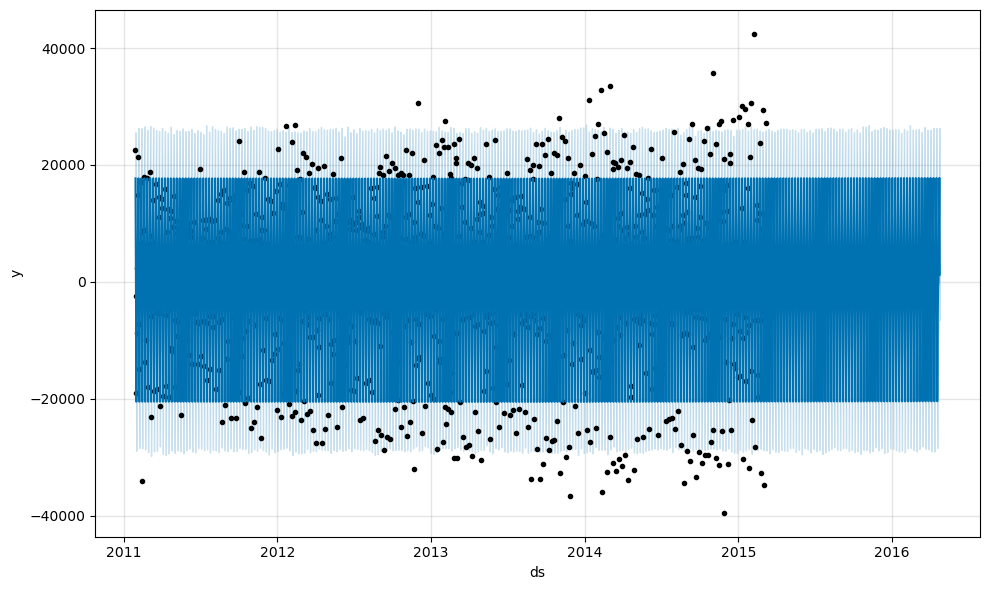

In [97]:
# test_predictor['cap'] = 60000
# test_predictor['floor'] = -50000
# future['cap'] = 60000
# future['floor'] = -50000
newm = Prophet(daily_seasonality = True, yearly_seasonality= False,growth='linear',changepoint_prior_scale=0.5)

test_predictor = train_adf[['ds','y']]
newm.fit(test_predictor)
future = newm.make_future_dataframe(periods=413)
fcst = newm.predict(future)
fig = newm.plot(fcst)

In [98]:

future

,ds
0,2011-01-29
1,2011-01-30
2,2011-01-31
3,2011-02-01
4,2011-02-02
...,...
1908,2016-04-20
1909,2016-04-21
1910,2016-04-22
1911,2016-04-23


In [99]:
forecast = new.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2011-01-29,69379.692763,60857.176084,77629.442330
1,2011-01-30,70395.729028,61781.861702,79566.913457
2,2011-01-31,50262.182728,41806.040570,58710.464200
3,2011-02-01,43899.331469,34934.282739,52375.184064
4,2011-02-02,43094.895300,34820.373477,52344.245590
...,...,...,...,...
1908,2016-04-20,95198.605485,82418.035309,108332.201865
1909,2016-04-21,95306.356699,81846.074640,108161.257475
1910,2016-04-22,104629.669292,91430.429578,117534.024954
1911,2016-04-23,122227.085063,109928.275284,135441.030205


In [100]:
predicted_data = fcst[['ds','yhat']]
predicted_data = predicted_data.iloc[1500:,:]

In [101]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(x=total_predictor["ds"], y=total_predictor["y"],
                     mode="lines", name="sales", line=dict(color="blue")), row=1, col=1)
fig.add_trace(go.Scatter(x=predicted_data["ds"], y=predicted_data["yhat"],
                     mode="lines", name="sales predicted", line=dict(color="red")), row=1, col=1)

In [102]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(new, initial='750 days', period='120 days', horizon = '365 days',parallel="processes")
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,4.440487e+07,6663.697809,4949.525392,0.062012,0.045803,0.060610,0.832192
1,38 days,4.362105e+07,6604.623539,4916.315928,0.061992,0.046078,0.060576,0.832192
2,39 days,4.471094e+07,6686.623960,5002.628649,0.063175,0.048111,0.061765,0.821918
3,40 days,4.534345e+07,6733.754763,5039.421073,0.063841,0.048111,0.062377,0.815068
4,41 days,4.710409e+07,6863.241856,5129.111558,0.064844,0.048309,0.063426,0.801370
...,...,...,...,...,...,...,...,...
324,361 days,1.912112e+08,13827.913133,11782.788124,0.132936,0.125031,0.132224,0.448630
325,362 days,1.929385e+08,13890.228854,11858.610256,0.133849,0.125586,0.133288,0.438356
326,363 days,1.938090e+08,13921.531576,11884.951137,0.133923,0.125586,0.133493,0.438356
327,364 days,1.972394e+08,14044.195456,11968.008429,0.134158,0.125586,0.133840,0.434932
